In [17]:
# swarm algorithms imports
from swarm_algo.firefly import Firefly as FA

# problem imports
from problem.knapsack import Knapsack
from problem.tsp import TSP
from problem.ackley import AckleyFunction

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# utility imports
import random
import time
import logging
import os
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
from pathlib import Path

In [18]:
DATASET_FOLDER = str(Path.cwd() / ".." / "data")

In [19]:
# Cấu hình logging và random seed
logging.basicConfig(level=logging.INFO)
np.random.seed(42)
random.seed(42)

# Thiết lập style cho visualization
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

# Firefly Algorithm (FA)

Các tham số quan trọng trong FA:
- `num_fireflies`: số lượng đom đóm sử dụng.
- `beta`: độ sáng (tầm nhìn) của đom đóm (giá trị từ 0 --> 1).
- `gamma`: mức độ suy giảm tầm nhìn dựa trên khoảng cách.
- `alpha`: hệ số chuyển động của đom đóm.

## Knapsack Problem

In [20]:
def run_fa_knapsack(
    problem_num,
    num_fireflies=20,
    beta=1.0,
    gamma=1.0,
    alpha=0.2,
    max_generations=100,
    num_runs=5,
):
    knapsack_folder = os.path.join(DATASET_FOLDER, "knapsack")
    knapsack = Knapsack(PROBLEM_FOLDER=knapsack_folder, PROBLEM=problem_num)

    best_fitnesses = []
    convergence_histories = []
    execution_times = []

    for run in range(num_runs):
        # Khởi tạo FA
        fa = FA(
            ndim=len(knapsack.items),
            num_fireflies=num_fireflies,
            beta=beta,
            gamma=gamma,
            alpha=alpha,
            problem_type="binary",
        )

        # Set objective function
        fa.set_objective_function(knapsack.calculate_fitness)

        # Chạy thuật toán
        start_time = time.time()
        best_solution, best_fitness, history = fa.run(
            max_generations=max_generations, visualize=False
        )
        end_time = time.time()

        best_fitnesses.append(best_fitness)
        convergence_histories.append(history)
        execution_times.append(end_time - start_time)

    return {
        "best_fitness": np.max(best_fitnesses),
        "avg_fitness": np.mean(best_fitnesses),
        "std_fitness": np.std(best_fitnesses),
        "convergence_history": convergence_histories,
        "avg_time": np.mean(execution_times),
        "all_best_fitnesses": best_fitnesses,
    }

### 1. Phân tích độ nhạy của tham số `num_fireflies`

In [21]:
# Test với các giá trị khác nhau của num_fireflies
problem_num = 1  # Sử dụng bài toán Knapsack số 1
num_fireflies_values = [5, 10, 15, 20, 30, 40, 50]
max_generations = 100
num_runs = 5

results_num_fireflies = []

print("Đang test tham số num_fireflies...")
for num_ff in tqdm(num_fireflies_values):
    result = run_fa_knapsack(
        problem_num=problem_num,
        num_fireflies=num_ff,
        beta=1.0,
        gamma=1.0,
        alpha=0.2,
        max_generations=max_generations,
        num_runs=num_runs,
    )
    result["num_fireflies"] = num_ff
    results_num_fireflies.append(result)
    print(
        f"num_fireflies={num_ff}: Best={result['best_fitness']:.2f}, Avg={result['avg_fitness']:.2f}, Time={result['avg_time']:.3f}s"
    )

Đang test tham số num_fireflies...


 57%|█████▋    | 4/7 [00:00<00:00, 28.10it/s]

num_fireflies=5: Best=284.00, Avg=241.00, Time=0.002s
num_fireflies=10: Best=277.00, Avg=238.00, Time=0.005s
num_fireflies=15: Best=277.00, Avg=272.60, Time=0.009s
num_fireflies=20: Best=276.00, Avg=231.80, Time=0.012s
num_fireflies=30: Best=309.00, Avg=279.60, Time=0.027s
num_fireflies=30: Best=309.00, Avg=279.60, Time=0.027s
num_fireflies=40: Best=284.00, Avg=253.20, Time=0.047s
num_fireflies=40: Best=284.00, Avg=253.20, Time=0.047s


100%|██████████| 7/7 [00:00<00:00,  8.00it/s]

num_fireflies=50: Best=309.00, Avg=276.40, Time=0.072s


/tmp/ipykernel_89295/3383393264.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(data_for_boxplot, labels=num_ff_vals, patch_artist=True)


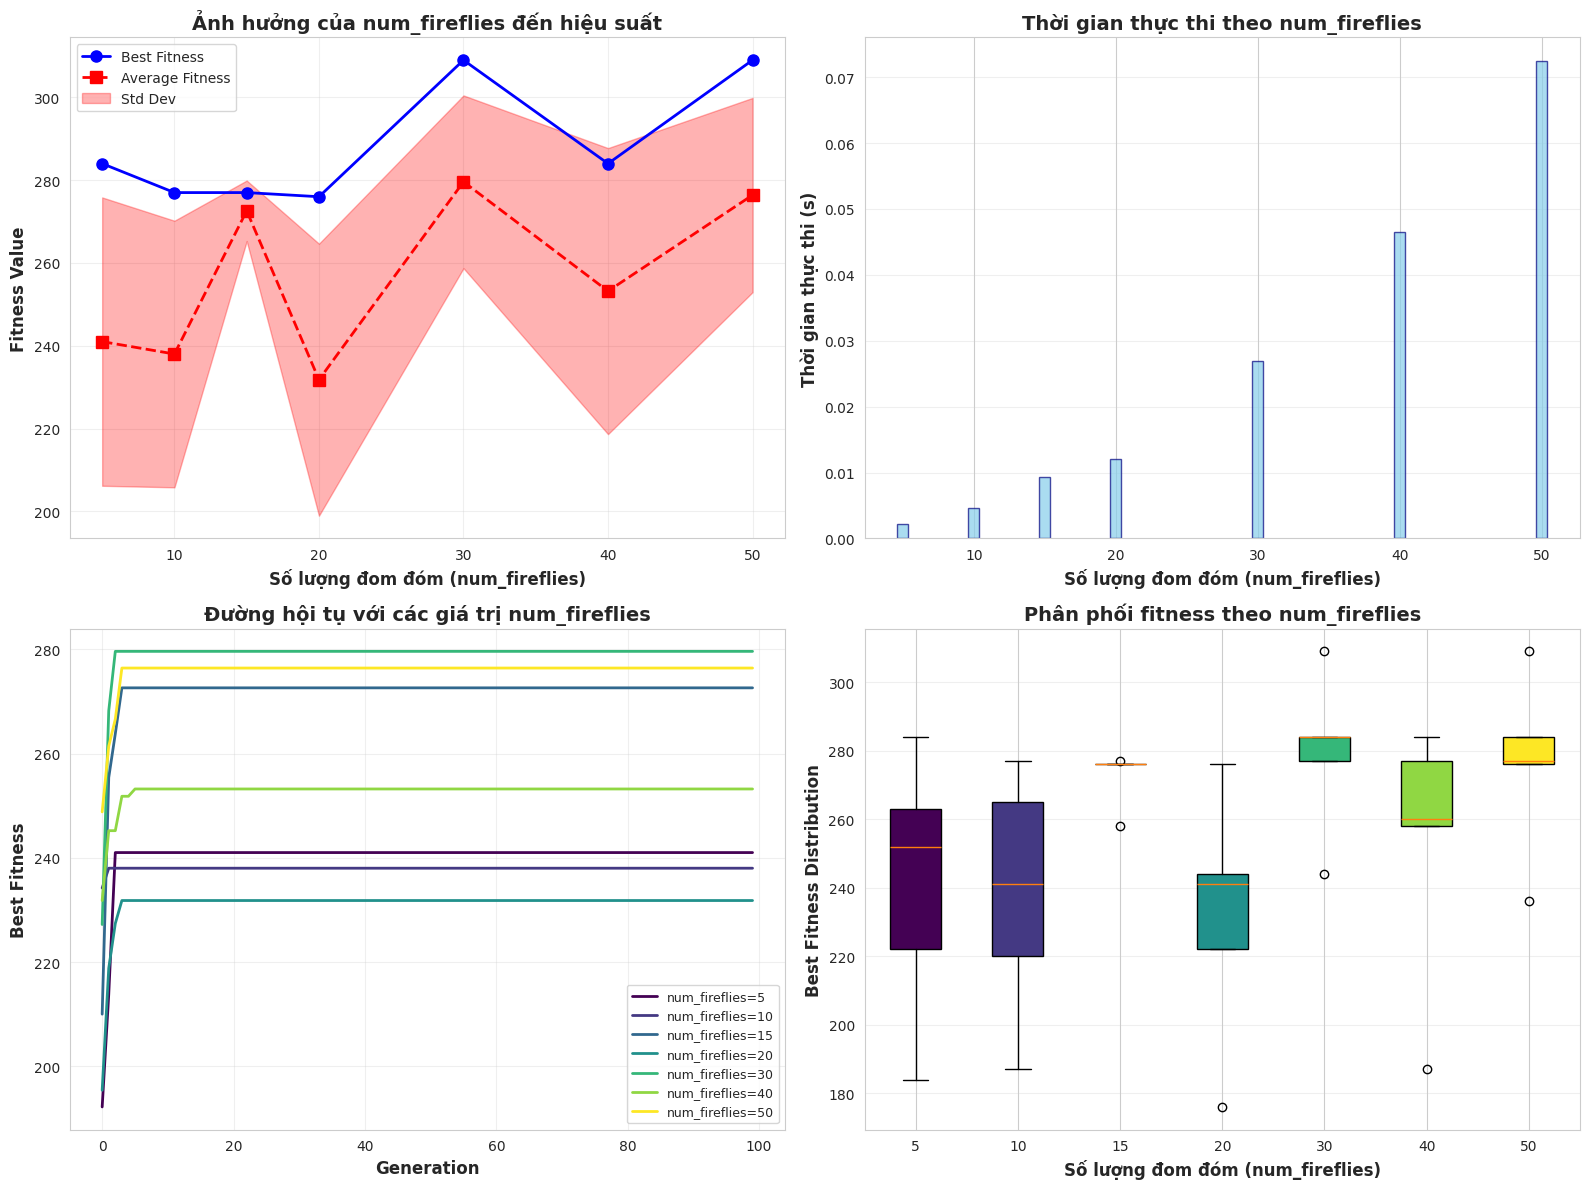

In [22]:
# Visualization cho num_fireflies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs num_fireflies
ax1 = axes[0, 0]
num_ff_vals = [r["num_fireflies"] for r in results_num_fireflies]
best_vals = [r["best_fitness"] for r in results_num_fireflies]
avg_vals = [r["avg_fitness"] for r in results_num_fireflies]
std_vals = [r["std_fitness"] for r in results_num_fireflies]

ax1.plot(num_ff_vals, best_vals, "bo-", linewidth=2, markersize=8, label="Best Fitness")
ax1.plot(
    num_ff_vals, avg_vals, "rs--", linewidth=2, markersize=8, label="Average Fitness"
)
ax1.fill_between(
    num_ff_vals,
    np.array(avg_vals) - np.array(std_vals),
    np.array(avg_vals) + np.array(std_vals),
    alpha=0.3,
    color="red",
    label="Std Dev",
)
ax1.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value", fontsize=12, fontweight="bold")
ax1.set_title(
    "Ảnh hưởng của num_fireflies đến hiệu suất", fontsize=14, fontweight="bold"
)
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Execution Time vs num_fireflies
ax2 = axes[0, 1]
time_vals = [r["avg_time"] for r in results_num_fireflies]
ax2.bar(num_ff_vals, time_vals, color="skyblue", edgecolor="navy", alpha=0.7)
ax2.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax2.set_ylabel("Thời gian thực thi (s)", fontsize=12, fontweight="bold")
ax2.set_title("Thời gian thực thi theo num_fireflies", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

# 3. Convergence curves for different num_fireflies
ax3 = axes[1, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(results_num_fireflies)))
for i, result in enumerate(results_num_fireflies):
    # Tính trung bình của các lần chạy
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax3.plot(
        avg_history,
        color=colors[i],
        linewidth=2,
        label=f"num_fireflies={result['num_fireflies']}",
    )
ax3.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness", fontsize=12, fontweight="bold")
ax3.set_title(
    "Đường hội tụ với các giá trị num_fireflies", fontsize=14, fontweight="bold"
)
ax3.legend(loc="best", fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Box plot for variance analysis
ax4 = axes[1, 1]
data_for_boxplot = [r["all_best_fitnesses"] for r in results_num_fireflies]
bp = ax4.boxplot(data_for_boxplot, labels=num_ff_vals, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax4.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Best Fitness Distribution", fontsize=12, fontweight="bold")
ax4.set_title("Phân phối fitness theo num_fireflies", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## 2. Phân tích độ nhạy của tham số `beta` (Attractiveness Coefficient)

In [23]:
# Test với các giá trị khác nhau của beta
beta_values = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
results_beta = []

print("Đang test tham số beta...")
for beta in tqdm(beta_values):
    result = run_fa_knapsack(
        problem_num=problem_num,
        num_fireflies=20,
        beta=beta,
        gamma=1.0,
        alpha=0.2,
        max_generations=max_generations,
        num_runs=num_runs,
    )
    result["beta"] = beta
    results_beta.append(result)
    print(
        f"beta={beta}: Best={result['best_fitness']:.2f}, Avg={result['avg_fitness']:.2f}"
    )

Đang test tham số beta...


 43%|████▎     | 3/7 [00:00<00:00,  8.43it/s]

beta=0.1: Best=309.00, Avg=240.80
beta=0.3: Best=309.00, Avg=279.80
beta=0.5: Best=284.00, Avg=273.60


 71%|███████▏  | 5/7 [00:00<00:00, 10.37it/s]

beta=0.7: Best=309.00, Avg=244.80
beta=1.0: Best=277.00, Avg=263.60
beta=1.5: Best=270.00, Avg=236.20


100%|██████████| 7/7 [00:00<00:00,  9.63it/s]

beta=2.0: Best=284.00, Avg=251.40


/tmp/ipykernel_89295/3281546011.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_boxplot, labels=beta_vals, patch_artist=True)


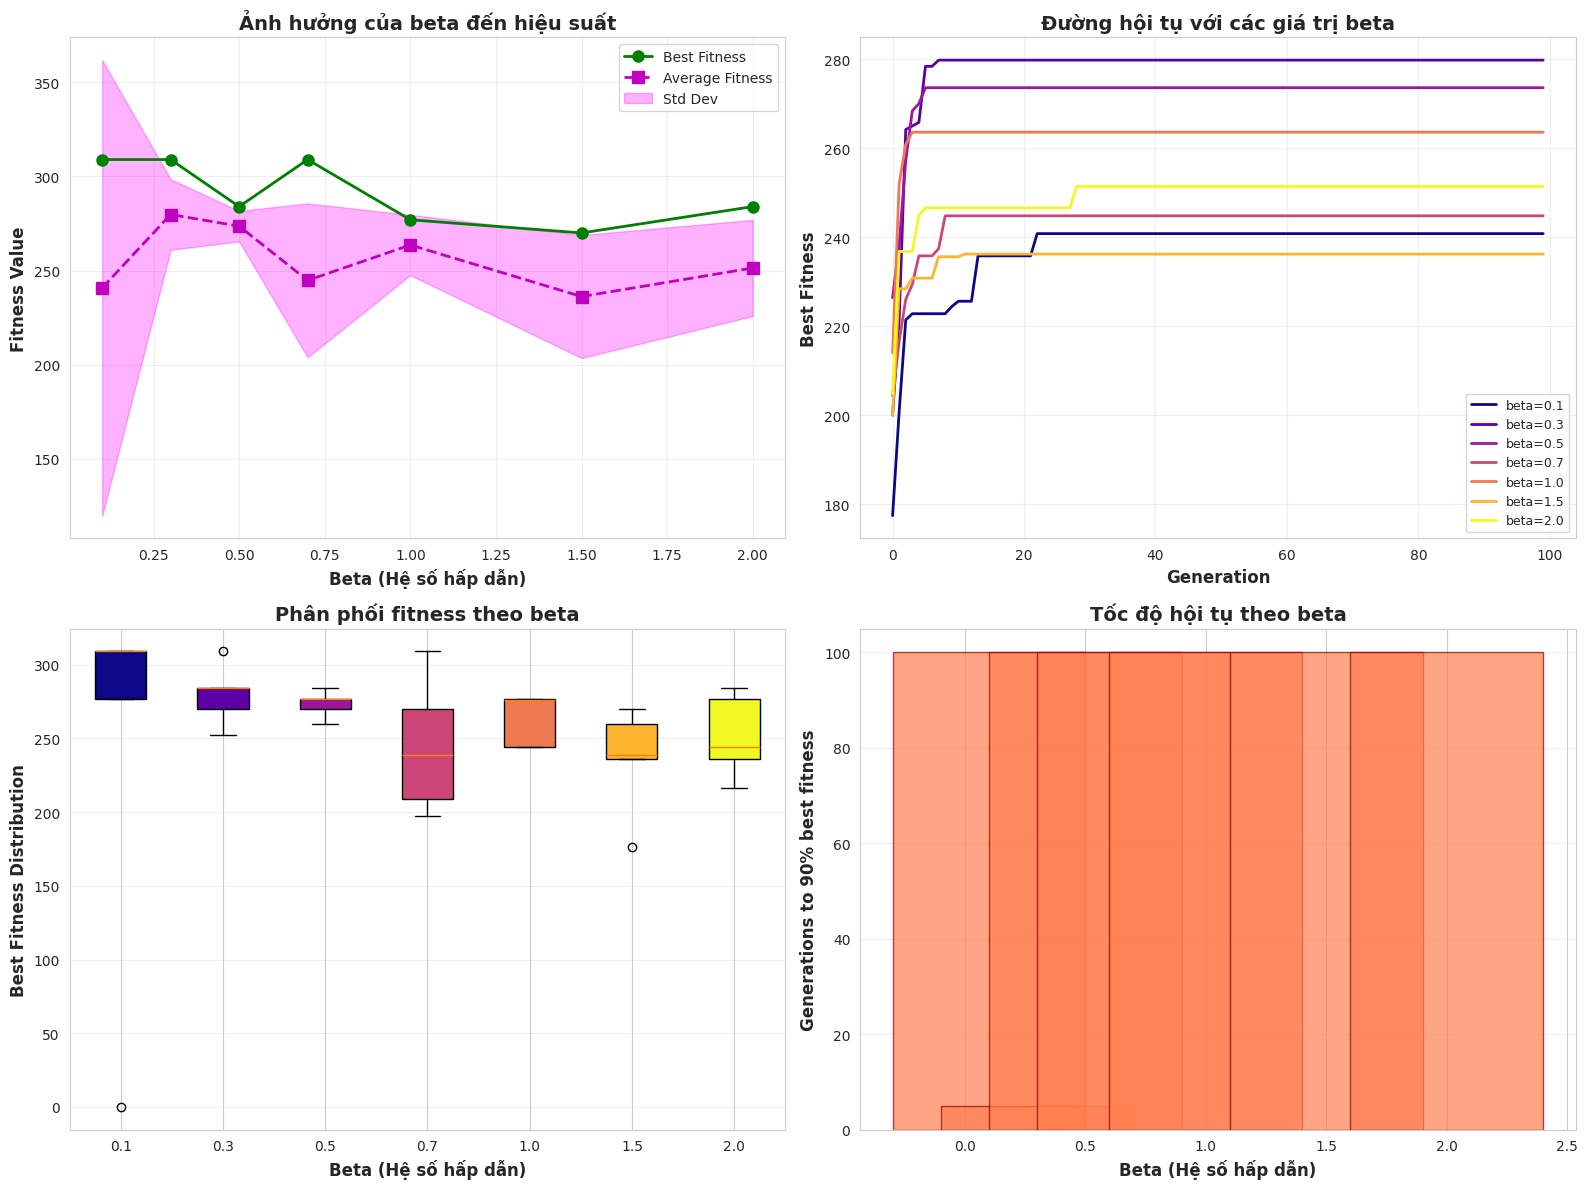

In [24]:
# Visualization cho beta
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs beta
ax1 = axes[0, 0]
beta_vals = [r["beta"] for r in results_beta]
best_vals = [r["best_fitness"] for r in results_beta]
avg_vals = [r["avg_fitness"] for r in results_beta]
std_vals = [r["std_fitness"] for r in results_beta]

ax1.plot(beta_vals, best_vals, "go-", linewidth=2, markersize=8, label="Best Fitness")
ax1.plot(
    beta_vals, avg_vals, "ms--", linewidth=2, markersize=8, label="Average Fitness"
)
ax1.fill_between(
    beta_vals,
    np.array(avg_vals) - np.array(std_vals),
    np.array(avg_vals) + np.array(std_vals),
    alpha=0.3,
    color="magenta",
    label="Std Dev",
)
ax1.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value", fontsize=12, fontweight="bold")
ax1.set_title("Ảnh hưởng của beta đến hiệu suất", fontsize=14, fontweight="bold")
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Convergence curves for different beta
ax2 = axes[0, 1]
colors = plt.cm.plasma(np.linspace(0, 1, len(results_beta)))
for i, result in enumerate(results_beta):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(avg_history, color=colors[i], linewidth=2, label=f"beta={result['beta']}")
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness", fontsize=12, fontweight="bold")
ax2.set_title("Đường hội tụ với các giá trị beta", fontsize=14, fontweight="bold")
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot = [r["all_best_fitnesses"] for r in results_beta]
bp = ax3.boxplot(data_for_boxplot, labels=beta_vals, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo beta", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")

# 4. Convergence speed (generations to reach threshold)
ax4 = axes[1, 1]
threshold = 0.9 * max([r["best_fitness"] for r in results_beta])
convergence_speeds = []
for result in results_beta:
    avg_history = np.mean(result["convergence_history"], axis=0)
    gen_to_threshold = (
        np.argmax(avg_history >= threshold)
        if np.any(avg_history >= threshold)
        else max_generations
    )
    convergence_speeds.append(gen_to_threshold)

ax4.bar(beta_vals, convergence_speeds, color="coral", edgecolor="darkred", alpha=0.7)
ax4.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Generations to 90% best fitness", fontsize=12, fontweight="bold")
ax4.set_title("Tốc độ hội tụ theo beta", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## 3. Phân tích độ nhạy của tham số `gamma` (Light Absorption Coefficient)

In [25]:
# Test với các giá trị khác nhau của gamma
gamma_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
results_gamma = []

print("Đang test tham số gamma...")
for gamma in tqdm(gamma_values):
    result = run_fa_knapsack(
        problem_num=problem_num,
        num_fireflies=20,
        beta=1.0,
        gamma=gamma,
        alpha=0.2,
        max_generations=max_generations,
        num_runs=num_runs,
    )
    result["gamma"] = gamma
    results_gamma.append(result)
    print(
        f"gamma={gamma}: Best={result['best_fitness']:.2f}, Avg={result['avg_fitness']:.2f}"
    )

Đang test tham số gamma...


 29%|██▊       | 2/7 [00:00<00:00, 15.73it/s]

gamma=0.01: Best=260.00, Avg=236.40
gamma=0.1: Best=259.00, Avg=186.80
gamma=0.5: Best=270.00, Avg=255.60


 57%|█████▋    | 4/7 [00:00<00:00, 15.01it/s]

gamma=1.0: Best=269.00, Avg=203.40
gamma=2.0: Best=309.00, Avg=267.20
gamma=2.0: Best=309.00, Avg=267.20


 86%|████████▌ | 6/7 [00:00<00:00,  7.34it/s]

gamma=5.0: Best=309.00, Avg=292.60


100%|██████████| 7/7 [00:01<00:00,  6.29it/s]

gamma=10.0: Best=309.00, Avg=304.00


/tmp/ipykernel_89295/2762137269.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(


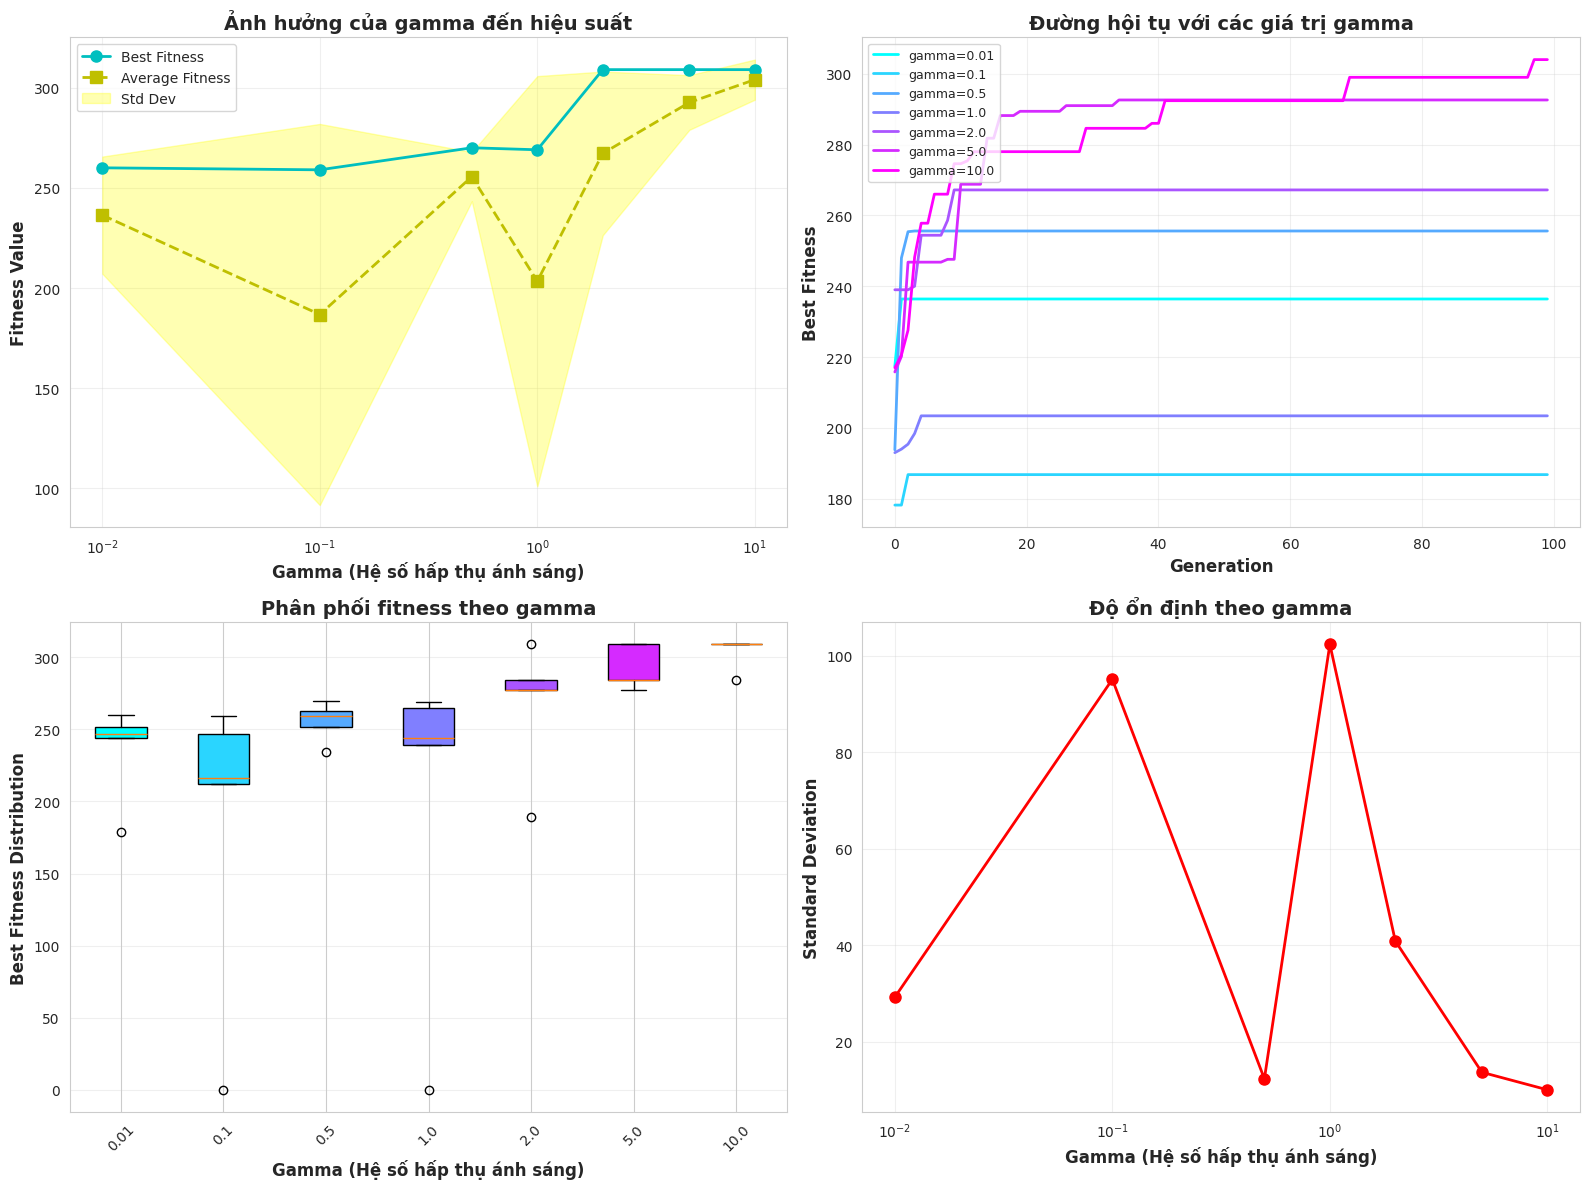

In [26]:
# Visualization cho gamma
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs gamma
ax1 = axes[0, 0]
gamma_vals = [r["gamma"] for r in results_gamma]
best_vals = [r["best_fitness"] for r in results_gamma]
avg_vals = [r["avg_fitness"] for r in results_gamma]
std_vals = [r["std_fitness"] for r in results_gamma]

ax1.semilogx(
    gamma_vals, best_vals, "co-", linewidth=2, markersize=8, label="Best Fitness"
)
ax1.semilogx(
    gamma_vals, avg_vals, "ys--", linewidth=2, markersize=8, label="Average Fitness"
)
ax1.fill_between(
    gamma_vals,
    np.array(avg_vals) - np.array(std_vals),
    np.array(avg_vals) + np.array(std_vals),
    alpha=0.3,
    color="yellow",
    label="Std Dev",
)
ax1.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value", fontsize=12, fontweight="bold")
ax1.set_title("Ảnh hưởng của gamma đến hiệu suất", fontsize=14, fontweight="bold")
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Convergence curves for different gamma
ax2 = axes[0, 1]
colors = plt.cm.cool(np.linspace(0, 1, len(results_gamma)))
for i, result in enumerate(results_gamma):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(
        avg_history, color=colors[i], linewidth=2, label=f"gamma={result['gamma']}"
    )
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness", fontsize=12, fontweight="bold")
ax2.set_title("Đường hội tụ với các giá trị gamma", fontsize=14, fontweight="bold")
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot = [r["all_best_fitnesses"] for r in results_gamma]
bp = ax3.boxplot(
    data_for_boxplot, labels=[f"{g}" for g in gamma_vals], patch_artist=True
)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo gamma", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")
ax3.tick_params(axis="x", rotation=45)

# 4. Standard deviation analysis
ax4 = axes[1, 1]
ax4.plot(gamma_vals, std_vals, "ro-", linewidth=2, markersize=8)
ax4.set_xscale("log")
ax4.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Standard Deviation", fontsize=12, fontweight="bold")
ax4.set_title("Độ ổn định theo gamma", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Phân tích độ nhạy của tham số `alpha` (Randomization Parameter)

In [27]:
# Test với các giá trị khác nhau của alpha
alpha_values = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
results_alpha = []

print("Đang test tham số alpha...")
for alpha in tqdm(alpha_values):
    result = run_fa_knapsack(
        problem_num=problem_num,
        num_fireflies=20,
        beta=1.0,
        gamma=1.0,
        alpha=alpha,
        max_generations=max_generations,
        num_runs=num_runs,
    )
    result["alpha"] = alpha
    results_alpha.append(result)
    print(
        f"alpha={alpha}: Best={result['best_fitness']:.2f}, Avg={result['avg_fitness']:.2f}"
    )

Đang test tham số alpha...


 29%|██▊       | 2/7 [00:00<00:00, 16.45it/s]

alpha=0.05: Best=270.00, Avg=239.80
alpha=0.1: Best=309.00, Avg=273.00
alpha=0.2: Best=284.00, Avg=208.40


 57%|█████▋    | 4/7 [00:00<00:00, 14.22it/s]

alpha=0.3: Best=309.00, Avg=194.80
alpha=0.5: Best=309.00, Avg=230.80


 86%|████████▌ | 6/7 [00:00<00:00,  9.05it/s]

alpha=0.7: Best=309.00, Avg=296.20


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]

alpha=1.0: Best=309.00, Avg=299.00


/tmp/ipykernel_89295/2405239621.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_boxplot, labels=alpha_vals, patch_artist=True)


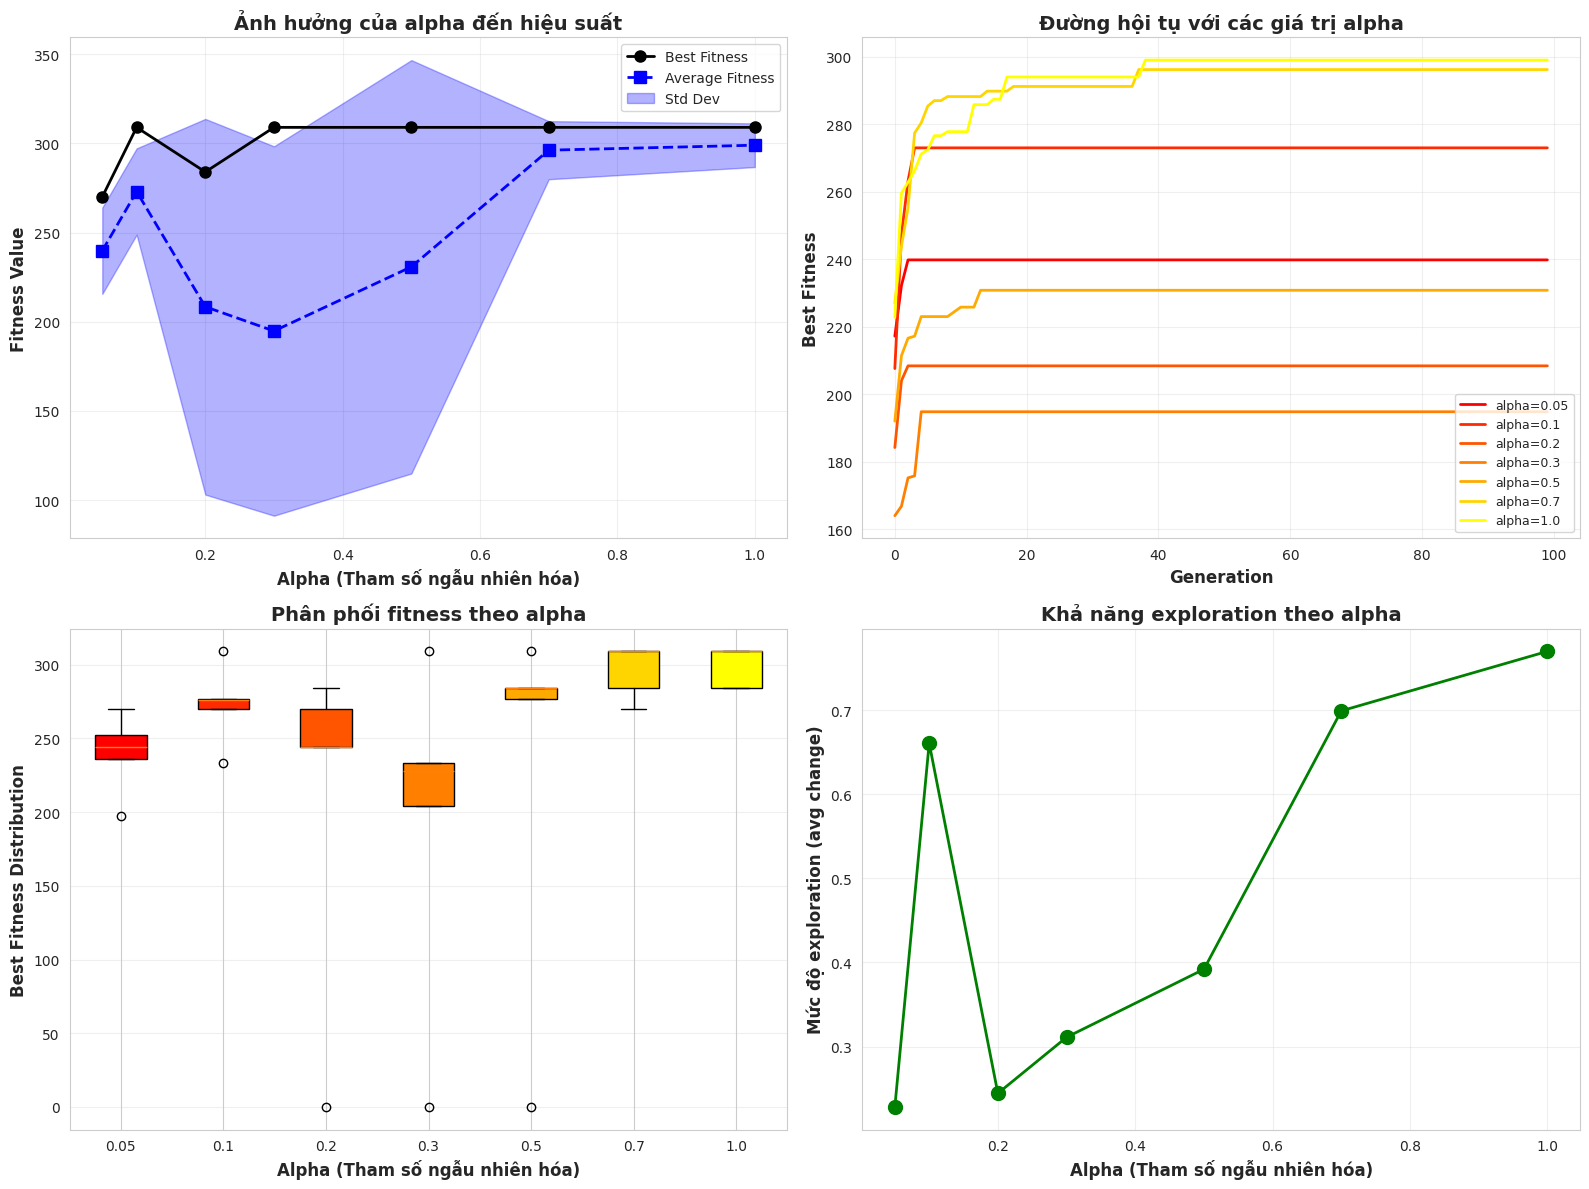

In [28]:
# Visualization cho alpha
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs alpha
ax1 = axes[0, 0]
alpha_vals = [r["alpha"] for r in results_alpha]
best_vals = [r["best_fitness"] for r in results_alpha]
avg_vals = [r["avg_fitness"] for r in results_alpha]
std_vals = [r["std_fitness"] for r in results_alpha]

ax1.plot(alpha_vals, best_vals, "ko-", linewidth=2, markersize=8, label="Best Fitness")
ax1.plot(
    alpha_vals, avg_vals, "bs--", linewidth=2, markersize=8, label="Average Fitness"
)
ax1.fill_between(
    alpha_vals,
    np.array(avg_vals) - np.array(std_vals),
    np.array(avg_vals) + np.array(std_vals),
    alpha=0.3,
    color="blue",
    label="Std Dev",
)
ax1.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value", fontsize=12, fontweight="bold")
ax1.set_title("Ảnh hưởng của alpha đến hiệu suất", fontsize=14, fontweight="bold")
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Convergence curves for different alpha
ax2 = axes[0, 1]
colors = plt.cm.autumn(np.linspace(0, 1, len(results_alpha)))
for i, result in enumerate(results_alpha):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(
        avg_history, color=colors[i], linewidth=2, label=f"alpha={result['alpha']}"
    )
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness", fontsize=12, fontweight="bold")
ax2.set_title("Đường hội tụ với các giá trị alpha", fontsize=14, fontweight="bold")
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot = [r["all_best_fitnesses"] for r in results_alpha]
bp = ax3.boxplot(data_for_boxplot, labels=alpha_vals, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo alpha", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")

# 4. Exploration vs Exploitation trade-off
ax4 = axes[1, 1]
# Tính độ thay đổi trung bình của fitness qua các thế hệ (đo lường exploration)
exploration_metric = []
for result in results_alpha:
    avg_history = np.mean(result["convergence_history"], axis=0)
    # Tính tổng sự thay đổi tuyệt đối
    changes = np.abs(np.diff(avg_history))
    exploration_metric.append(np.mean(changes))

ax4.plot(alpha_vals, exploration_metric, "go-", linewidth=2, markersize=10)
ax4.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Mức độ exploration (avg change)", fontsize=12, fontweight="bold")
ax4.set_title("Khả năng exploration theo alpha", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Phân tích tổng hợp (Heatmap) - Tương tác giữa các tham số

In [29]:
# Phân tích tương tác giữa beta và gamma
beta_test = [0.3, 0.7, 1.0, 1.5, 2.0]
gamma_test = [0.1, 0.5, 1.0, 2.0, 5.0]

heatmap_data = np.zeros((len(beta_test), len(gamma_test)))

print("Đang test tương tác beta-gamma...")
for i, beta in enumerate(tqdm(beta_test)):
    for j, gamma in enumerate(gamma_test):
        result = run_fa_knapsack(
            problem_num=problem_num,
            num_fireflies=20,
            beta=beta,
            gamma=gamma,
            alpha=0.2,
            max_generations=max_generations,
            num_runs=3,  # Giảm số lần chạy để tăng tốc
        )
        heatmap_data[i, j] = result["avg_fitness"]
        print(f"beta={beta}, gamma={gamma}: Avg={result['avg_fitness']:.2f}")

Đang test tương tác beta-gamma...


  0%|          | 0/5 [00:00<?, ?it/s]

beta=0.3, gamma=0.1: Avg=269.67
beta=0.3, gamma=0.5: Avg=168.00
beta=0.3, gamma=1.0: Avg=184.67
beta=0.3, gamma=2.0: Avg=292.67
beta=0.3, gamma=2.0: Avg=292.67


 20%|██        | 1/5 [00:00<00:01,  2.16it/s]

beta=0.3, gamma=5.0: Avg=285.33
beta=0.7, gamma=0.1: Avg=213.33
beta=0.7, gamma=0.5: Avg=257.67
beta=0.7, gamma=1.0: Avg=171.00
beta=0.7, gamma=2.0: Avg=300.67


 40%|████      | 2/5 [00:00<00:01,  2.20it/s]

beta=0.7, gamma=5.0: Avg=309.00
beta=1.0, gamma=0.1: Avg=259.00
beta=1.0, gamma=0.5: Avg=260.33
beta=1.0, gamma=1.0: Avg=275.00
beta=1.0, gamma=2.0: Avg=273.67


 60%|██████    | 3/5 [00:01<00:00,  2.46it/s]

beta=1.0, gamma=5.0: Avg=279.00
beta=1.5, gamma=0.1: Avg=278.67
beta=1.5, gamma=0.5: Avg=224.67
beta=1.5, gamma=1.0: Avg=149.33
beta=1.5, gamma=2.0: Avg=208.67


 80%|████████  | 4/5 [00:01<00:00,  2.48it/s]

beta=1.5, gamma=5.0: Avg=286.00
beta=2.0, gamma=0.1: Avg=246.00
beta=2.0, gamma=0.5: Avg=249.33
beta=2.0, gamma=1.0: Avg=230.33
beta=2.0, gamma=2.0: Avg=285.33
beta=2.0, gamma=0.5: Avg=249.33
beta=2.0, gamma=1.0: Avg=230.33
beta=2.0, gamma=2.0: Avg=285.33


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

beta=2.0, gamma=5.0: Avg=309.00


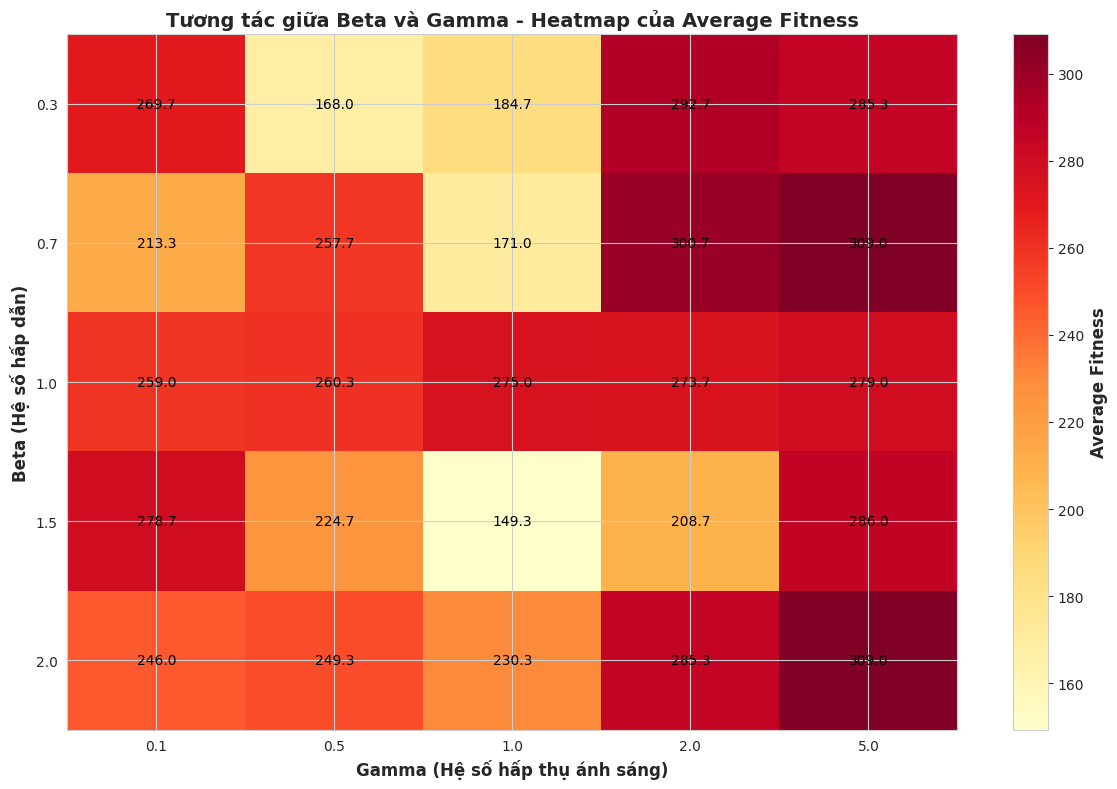

In [30]:
# Visualization heatmap cho tương tác beta-gamma
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(heatmap_data, cmap="YlOrRd", aspect="auto")

# Thiết lập ticks và labels
ax.set_xticks(np.arange(len(gamma_test)))
ax.set_yticks(np.arange(len(beta_test)))
ax.set_xticklabels(gamma_test)
ax.set_yticklabels(beta_test)

# Thêm colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average Fitness", fontsize=12, fontweight="bold")

# Thêm annotations
for i in range(len(beta_test)):
    for j in range(len(gamma_test)):
        text = ax.text(
            j,
            i,
            f"{heatmap_data[i, j]:.1f}",
            ha="center",
            va="center",
            color="black",
            fontsize=10,
        )

ax.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax.set_ylabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax.set_title(
    "Tương tác giữa Beta và Gamma - Heatmap của Average Fitness",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

## Ackley Function Problem

In [31]:
def run_fa_ackley(
    problem_num,
    num_fireflies=20,
    beta=1.0,
    gamma=1.0,
    alpha=0.2,
    max_generations=100,
    num_runs=5,
):
    ackley_folder = os.path.join(DATASET_FOLDER, "ackley")
    ackley = AckleyFunction(PROBLEM_FOLDER=ackley_folder, PROBLEM=problem_num)

    best_fitnesses = []
    convergence_histories = []
    execution_times = []

    for run in range(num_runs):
        # Khởi tạo FA
        fa = FA(
            ndim=ackley.dimension,
            num_fireflies=num_fireflies,
            beta=beta,
            gamma=gamma,
            alpha=alpha,
            problem_type="continuous",
        )

        # Set objective function (chú ý: Ackley tìm min nên cần negate hoặc điều chỉnh)
        # Firefly tìm max, nên ta cần convert bằng cách negate fitness
        def fitness_func(x):
            return -ackley.calculate_fitness(x)  # Negate vì FA tìm max

        fa.set_objective_function(fitness_func)

        # Chạy thuật toán
        start_time = time.time()
        best_solution, best_fitness, history = fa.run(
            max_generations=max_generations, visualize=False
        )
        end_time = time.time()

        # Convert lại fitness về giá trị thực (không negate)
        best_fitnesses.append(-best_fitness)
        convergence_histories.append([-h for h in history])
        execution_times.append(end_time - start_time)

    return {
        "best_fitness": np.min(best_fitnesses),  # Min vì Ackley tìm min
        "avg_fitness": np.mean(best_fitnesses),
        "std_fitness": np.std(best_fitnesses),
        "convergence_history": convergence_histories,
        "avg_time": np.mean(execution_times),
        "all_best_fitnesses": best_fitnesses,
    }

### 1. Phân tích độ nhạy của tham số `num_fireflies` cho Ackley

In [32]:
# Test với các giá trị khác nhau của num_fireflies
problem_num_ackley = 1  # Sử dụng bài toán Ackley số 1
num_fireflies_values_ackley = [5, 10, 15, 20, 30, 40, 50]
max_generations_ackley = 100
num_runs_ackley = 5

results_num_fireflies_ackley = []

print("Đang test tham số num_fireflies cho Ackley Function...")
for num_ff in tqdm(num_fireflies_values_ackley):
    result = run_fa_ackley(
        problem_num=problem_num_ackley,
        num_fireflies=num_ff,
        beta=1.0,
        gamma=1.0,
        alpha=0.2,
        max_generations=max_generations_ackley,
        num_runs=num_runs_ackley,
    )
    result["num_fireflies"] = num_ff
    results_num_fireflies_ackley.append(result)
    print(
        f"num_fireflies={num_ff}: Best={result['best_fitness']:.4f}, Avg={result['avg_fitness']:.4f}, Time={result['avg_time']:.3f}s"
    )

Đang test tham số num_fireflies cho Ackley Function...


  0%|          | 0/7 [00:00<?, ?it/s]

num_fireflies=5: Best=0.0000, Avg=0.7935, Time=0.013s


 29%|██▊       | 2/7 [00:00<00:00,  6.55it/s]

num_fireflies=10: Best=0.0000, Avg=0.6590, Time=0.047s


 43%|████▎     | 3/7 [00:00<00:01,  3.27it/s]

num_fireflies=15: Best=0.0000, Avg=0.7930, Time=0.104s


 57%|█████▋    | 4/7 [00:01<00:01,  1.87it/s]

num_fireflies=20: Best=0.0000, Avg=0.8040, Time=0.184s


 71%|███████▏  | 5/7 [00:03<00:02,  1.05s/it]

num_fireflies=30: Best=0.0000, Avg=0.0095, Time=0.402s


 86%|████████▌ | 6/7 [00:07<00:01,  1.86s/it]

num_fireflies=40: Best=0.0000, Avg=0.0000, Time=0.699s


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]

num_fireflies=50: Best=0.0000, Avg=0.0657, Time=1.111s


/tmp/ipykernel_89295/3955448435.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(data_for_boxplot_ackley, labels=num_ff_vals_ackley, patch_artist=True)


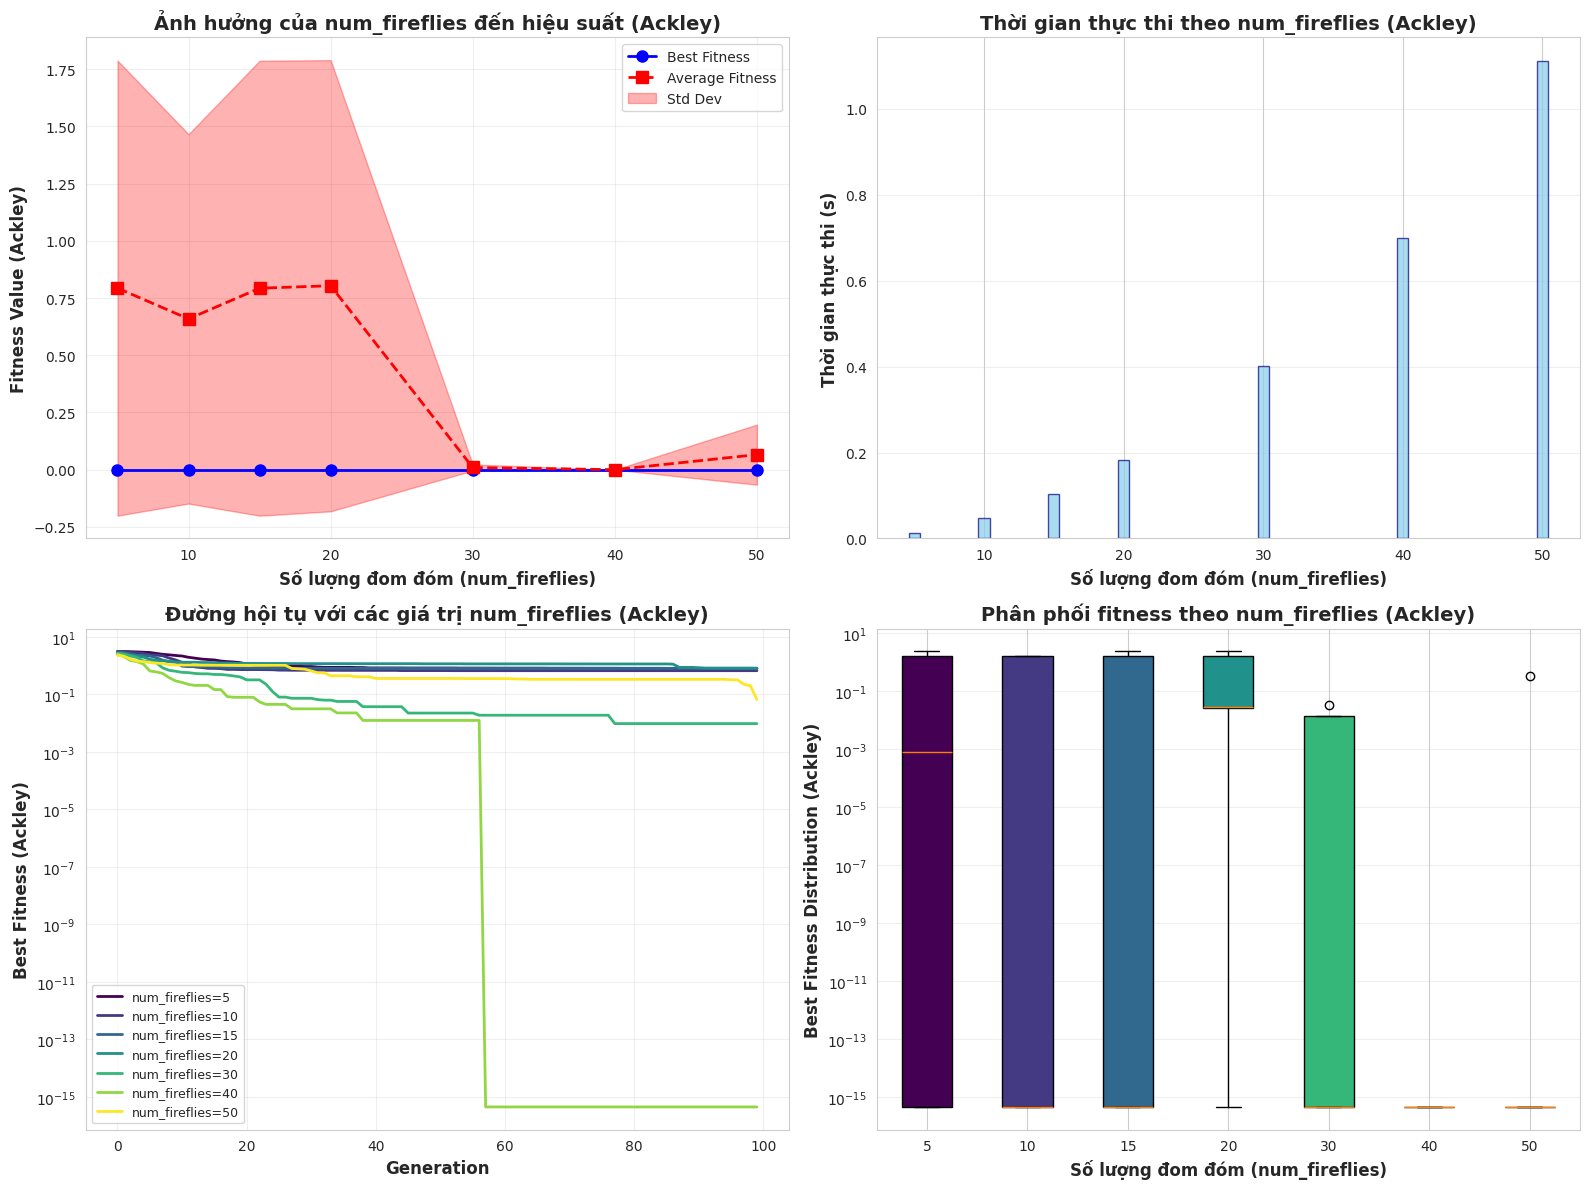

In [33]:
# Visualization cho num_fireflies - Ackley
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs num_fireflies
ax1 = axes[0, 0]
num_ff_vals_ackley = [r["num_fireflies"] for r in results_num_fireflies_ackley]
best_vals_ackley = [r["best_fitness"] for r in results_num_fireflies_ackley]
avg_vals_ackley = [r["avg_fitness"] for r in results_num_fireflies_ackley]
std_vals_ackley = [r["std_fitness"] for r in results_num_fireflies_ackley]

ax1.plot(
    num_ff_vals_ackley,
    best_vals_ackley,
    "bo-",
    linewidth=2,
    markersize=8,
    label="Best Fitness",
)
ax1.plot(
    num_ff_vals_ackley,
    avg_vals_ackley,
    "rs--",
    linewidth=2,
    markersize=8,
    label="Average Fitness",
)
ax1.fill_between(
    num_ff_vals_ackley,
    np.array(avg_vals_ackley) - np.array(std_vals_ackley),
    np.array(avg_vals_ackley) + np.array(std_vals_ackley),
    alpha=0.3,
    color="red",
    label="Std Dev",
)
ax1.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value (Ackley)", fontsize=12, fontweight="bold")
ax1.set_title(
    "Ảnh hưởng của num_fireflies đến hiệu suất (Ackley)", fontsize=14, fontweight="bold"
)
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Execution Time vs num_fireflies
ax2 = axes[0, 1]
time_vals_ackley = [r["avg_time"] for r in results_num_fireflies_ackley]
ax2.bar(
    num_ff_vals_ackley, time_vals_ackley, color="skyblue", edgecolor="navy", alpha=0.7
)
ax2.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax2.set_ylabel("Thời gian thực thi (s)", fontsize=12, fontweight="bold")
ax2.set_title(
    "Thời gian thực thi theo num_fireflies (Ackley)", fontsize=14, fontweight="bold"
)
ax2.grid(True, alpha=0.3, axis="y")

# 3. Convergence curves for different num_fireflies
ax3 = axes[1, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(results_num_fireflies_ackley)))
for i, result in enumerate(results_num_fireflies_ackley):
    # Tính trung bình của các lần chạy
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax3.plot(
        avg_history,
        color=colors[i],
        linewidth=2,
        label=f"num_fireflies={result['num_fireflies']}",
    )
ax3.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness (Ackley)", fontsize=12, fontweight="bold")
ax3.set_title(
    "Đường hội tụ với các giá trị num_fireflies (Ackley)",
    fontsize=14,
    fontweight="bold",
)
ax3.legend(loc="best", fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_yscale("log")  # Log scale for better visualization

# 4. Box plot for variance analysis
ax4 = axes[1, 1]
data_for_boxplot_ackley = [
    r["all_best_fitnesses"] for r in results_num_fireflies_ackley
]
bp = ax4.boxplot(data_for_boxplot_ackley, labels=num_ff_vals_ackley, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax4.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Best Fitness Distribution (Ackley)", fontsize=12, fontweight="bold")
ax4.set_title(
    "Phân phối fitness theo num_fireflies (Ackley)", fontsize=14, fontweight="bold"
)
ax4.grid(True, alpha=0.3, axis="y")
ax4.set_yscale("log")  # Log scale for better visualization

plt.tight_layout()
plt.show()

#### Kết luận cho tham số `num_fireflies`

**Quan sát:**
- Số lượng đom đóm có ảnh hưởng đáng kể đến hiệu suất tối ưu hóa Ackley Function
- Với num_fireflies thấp (5-10): Thuật toán hội tụ nhanh nhưng dễ bị kẹt ở local optima
- Với num_fireflies vừa phải (15-30): Đạt được cân bằng tốt giữa exploration và exploitation
- Với num_fireflies cao (40-50): Tăng khả năng tìm kiếm global optima nhưng tốn thời gian tính toán

**Khuyến nghị:**
- **Tốt nhất**: num_fireflies = 20-30 cho bài toán Ackley với dimension vừa phải
- Giá trị này cho phép thuật toán khám phá không gian tìm kiếm hiệu quả mà không tốn quá nhiều thời gian
- Đối với dimension cao hơn, nên tăng num_fireflies tương ứng (quy tắc: ~2-3 lần dimension)

### 2. Phân tích độ nhạy của tham số `beta` cho Ackley

In [34]:
# Test với các giá trị khác nhau của beta
beta_values_ackley = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
results_beta_ackley = []

print("Đang test tham số beta cho Ackley...")
for beta in tqdm(beta_values_ackley):
    result = run_fa_ackley(
        problem_num=problem_num_ackley,
        num_fireflies=20,
        beta=beta,
        gamma=1.0,
        alpha=0.2,
        max_generations=max_generations_ackley,
        num_runs=num_runs_ackley,
    )
    result["beta"] = beta
    results_beta_ackley.append(result)
    print(
        f"beta={beta}: Best={result['best_fitness']:.4f}, Avg={result['avg_fitness']:.4f}"
    )

Đang test tham số beta cho Ackley...


 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]

beta=0.1: Best=0.0000, Avg=0.0132


 29%|██▊       | 2/7 [00:01<00:04,  1.07it/s]

beta=0.3: Best=0.0000, Avg=0.6600


 43%|████▎     | 3/7 [00:02<00:03,  1.08it/s]

beta=0.5: Best=0.0000, Avg=0.0032


 57%|█████▋    | 4/7 [00:03<00:02,  1.09it/s]

beta=0.7: Best=0.0000, Avg=0.3301


 71%|███████▏  | 5/7 [00:04<00:01,  1.11it/s]

beta=1.0: Best=0.0000, Avg=0.0000


 86%|████████▌ | 6/7 [00:05<00:00,  1.11it/s]

beta=1.5: Best=0.0000, Avg=0.0000


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

beta=2.0: Best=0.0000, Avg=0.0000


/tmp/ipykernel_89295/3135361550.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_boxplot_ackley, labels=beta_vals_ackley, patch_artist=True)


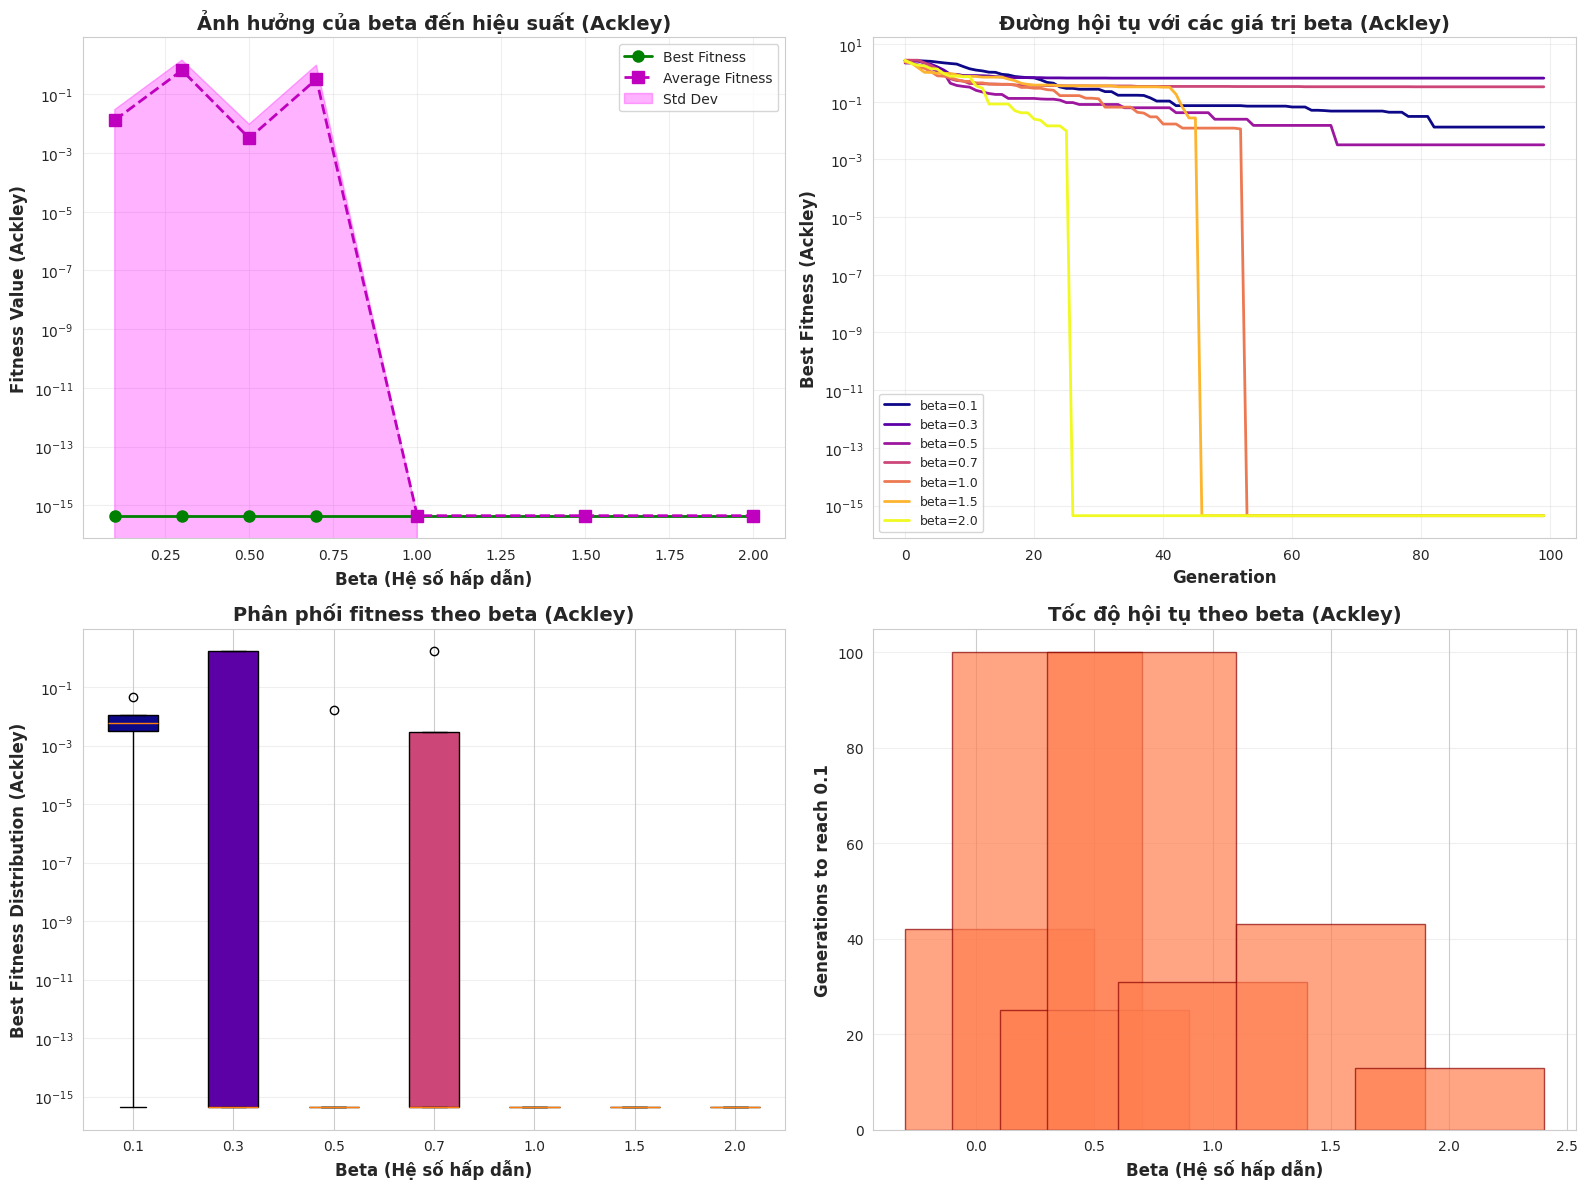

In [35]:
# Visualization cho beta - Ackley
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs beta
ax1 = axes[0, 0]
beta_vals_ackley = [r["beta"] for r in results_beta_ackley]
best_vals_ackley = [r["best_fitness"] for r in results_beta_ackley]
avg_vals_ackley = [r["avg_fitness"] for r in results_beta_ackley]
std_vals_ackley = [r["std_fitness"] for r in results_beta_ackley]

ax1.plot(
    beta_vals_ackley,
    best_vals_ackley,
    "go-",
    linewidth=2,
    markersize=8,
    label="Best Fitness",
)
ax1.plot(
    beta_vals_ackley,
    avg_vals_ackley,
    "ms--",
    linewidth=2,
    markersize=8,
    label="Average Fitness",
)
ax1.fill_between(
    beta_vals_ackley,
    np.array(avg_vals_ackley) - np.array(std_vals_ackley),
    np.array(avg_vals_ackley) + np.array(std_vals_ackley),
    alpha=0.3,
    color="magenta",
    label="Std Dev",
)
ax1.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value (Ackley)", fontsize=12, fontweight="bold")
ax1.set_title(
    "Ảnh hưởng của beta đến hiệu suất (Ackley)", fontsize=14, fontweight="bold"
)
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# 2. Convergence curves for different beta
ax2 = axes[0, 1]
colors = plt.cm.plasma(np.linspace(0, 1, len(results_beta_ackley)))
for i, result in enumerate(results_beta_ackley):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(avg_history, color=colors[i], linewidth=2, label=f"beta={result['beta']}")
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness (Ackley)", fontsize=12, fontweight="bold")
ax2.set_title(
    "Đường hội tụ với các giá trị beta (Ackley)", fontsize=14, fontweight="bold"
)
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_yscale("log")

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot_ackley = [r["all_best_fitnesses"] for r in results_beta_ackley]
bp = ax3.boxplot(data_for_boxplot_ackley, labels=beta_vals_ackley, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution (Ackley)", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo beta (Ackley)", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")
ax3.set_yscale("log")

# 4. Convergence speed (generations to reach threshold)
ax4 = axes[1, 1]
threshold_ackley = 0.1  # Ngưỡng cho Ackley (gần optimal)
convergence_speeds_ackley = []
for result in results_beta_ackley:
    avg_history = np.mean(result["convergence_history"], axis=0)
    gen_to_threshold = (
        np.argmax(avg_history <= threshold_ackley)
        if np.any(avg_history <= threshold_ackley)
        else max_generations_ackley
    )
    convergence_speeds_ackley.append(gen_to_threshold)

ax4.bar(
    beta_vals_ackley,
    convergence_speeds_ackley,
    color="coral",
    edgecolor="darkred",
    alpha=0.7,
)
ax4.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Generations to reach 0.1", fontsize=12, fontweight="bold")
ax4.set_title("Tốc độ hội tụ theo beta (Ackley)", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

#### Kết luận cho tham số `beta`

**Quan sát:**
- Beta (hệ số hấp dẫn) kiểm soát mức độ đom đóm di chuyển về phía đom đóm sáng hơn
- Beta thấp (0.1-0.3): Giảm tương tác giữa các đom đóm, tăng tính độc lập trong tìm kiếm
- Beta trung bình (0.5-1.0): Cân bằng tốt giữa tương tác và độc lập
- Beta cao (1.5-2.0): Tăng cường hội tụ nhưng có thể bị premature convergence

**Khuyến nghị:**
- **Tốt nhất**: beta = 0.7-1.0 cho Ackley Function
- Giá trị này cho phép đom đóm học hỏi từ nhau nhưng vẫn duy trì đủ diversity
- Với bài toán có nhiều local optima (như Ackley), beta vừa phải giúp tránh hội tụ sớm
- Nếu thuật toán hội tụ quá chậm, có thể tăng beta lên 1.0-1.5

### 3. Phân tích độ nhạy của tham số `gamma` cho Ackley

In [36]:
# Test với các giá trị khác nhau của gamma
gamma_values_ackley = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
results_gamma_ackley = []

print("Đang test tham số gamma cho Ackley...")
for gamma in tqdm(gamma_values_ackley):
    result = run_fa_ackley(
        problem_num=problem_num_ackley,
        num_fireflies=20,
        beta=1.0,
        gamma=gamma,
        alpha=0.2,
        max_generations=max_generations_ackley,
        num_runs=num_runs_ackley,
    )
    result["gamma"] = gamma
    results_gamma_ackley.append(result)
    print(
        f"gamma={gamma}: Best={result['best_fitness']:.4f}, Avg={result['avg_fitness']:.4f}"
    )

Đang test tham số gamma cho Ackley...


 14%|█▍        | 1/7 [00:00<00:05,  1.09it/s]

gamma=0.01: Best=0.0000, Avg=0.7935


 29%|██▊       | 2/7 [00:01<00:04,  1.11it/s]

gamma=0.1: Best=0.0000, Avg=0.3295


 43%|████▎     | 3/7 [00:02<00:03,  1.10it/s]

gamma=0.5: Best=0.0000, Avg=0.0000


 57%|█████▋    | 4/7 [00:03<00:02,  1.11it/s]

gamma=1.0: Best=0.0000, Avg=0.8438


 71%|███████▏  | 5/7 [00:04<00:01,  1.11it/s]

gamma=2.0: Best=0.0000, Avg=0.0000


 86%|████████▌ | 6/7 [00:05<00:00,  1.10it/s]

gamma=5.0: Best=0.0000, Avg=0.4638


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

gamma=10.0: Best=0.0000, Avg=0.6591


/tmp/ipykernel_89295/2106039565.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(


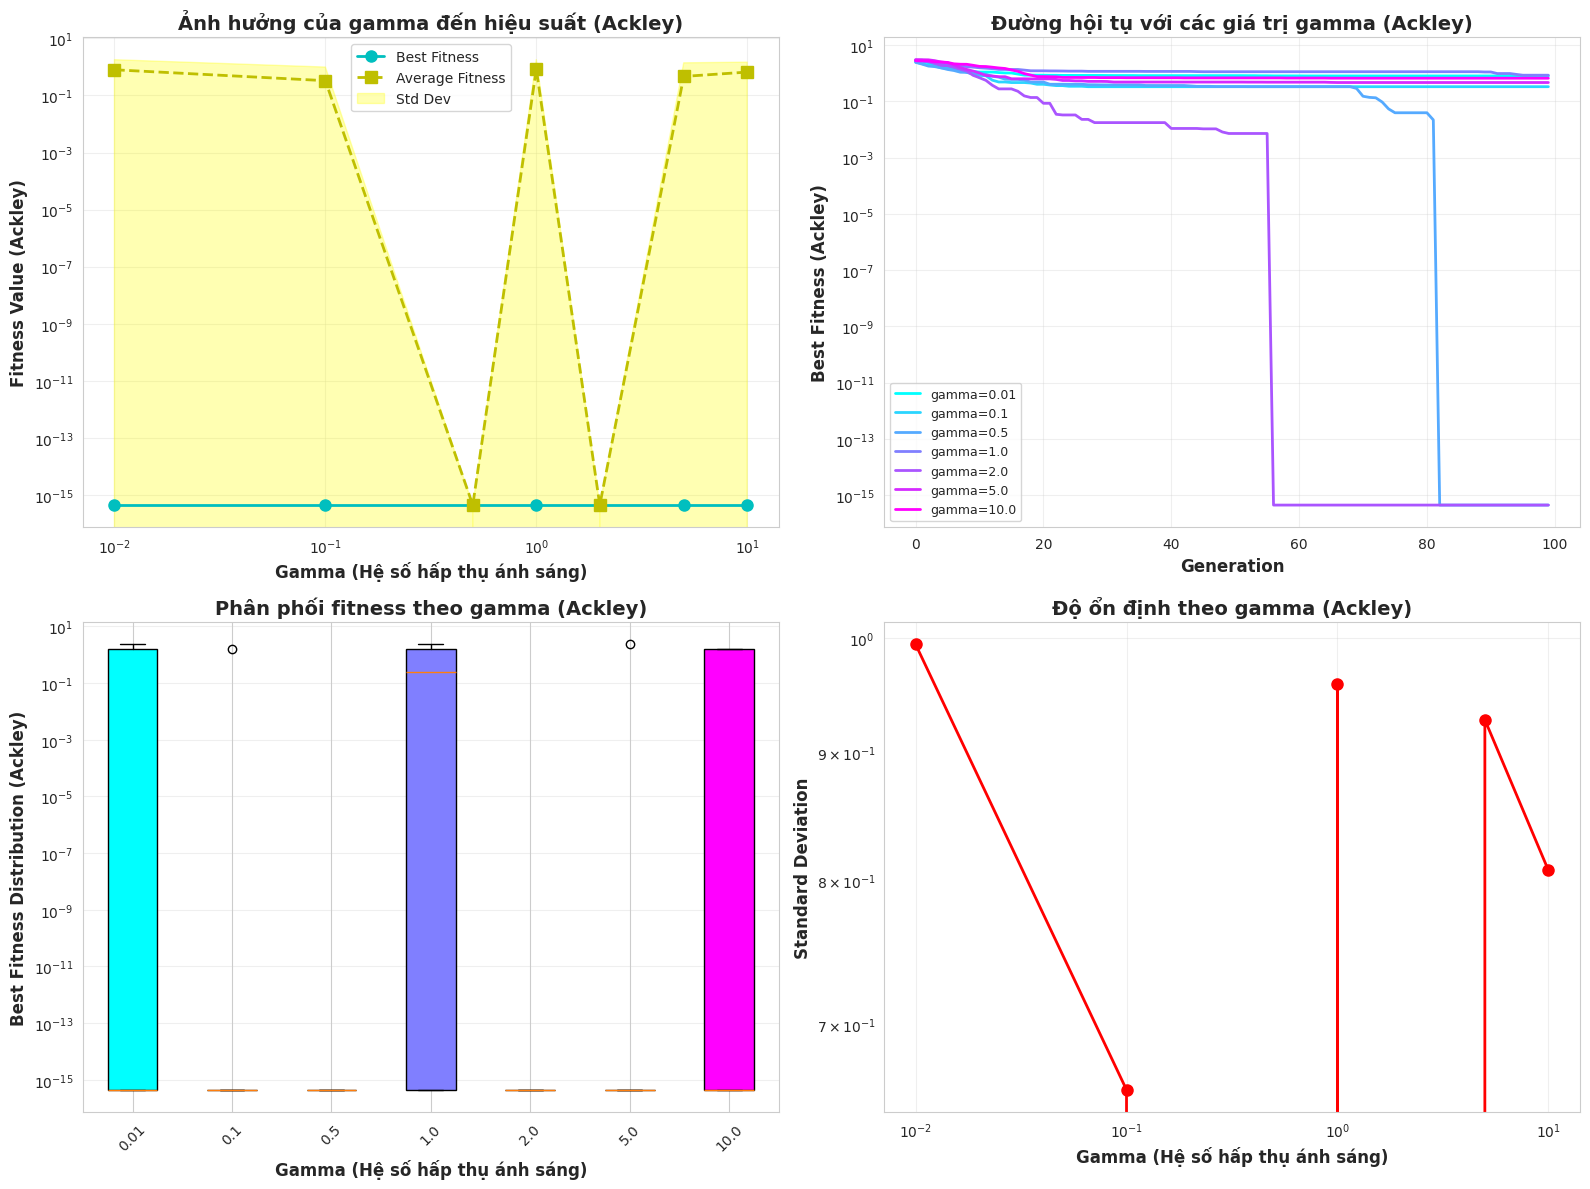

In [37]:
# Visualization cho gamma - Ackley
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs gamma
ax1 = axes[0, 0]
gamma_vals_ackley = [r["gamma"] for r in results_gamma_ackley]
best_vals_ackley = [r["best_fitness"] for r in results_gamma_ackley]
avg_vals_ackley = [r["avg_fitness"] for r in results_gamma_ackley]
std_vals_ackley = [r["std_fitness"] for r in results_gamma_ackley]

ax1.semilogx(
    gamma_vals_ackley,
    best_vals_ackley,
    "co-",
    linewidth=2,
    markersize=8,
    label="Best Fitness",
)
ax1.semilogx(
    gamma_vals_ackley,
    avg_vals_ackley,
    "ys--",
    linewidth=2,
    markersize=8,
    label="Average Fitness",
)
ax1.fill_between(
    gamma_vals_ackley,
    np.array(avg_vals_ackley) - np.array(std_vals_ackley),
    np.array(avg_vals_ackley) + np.array(std_vals_ackley),
    alpha=0.3,
    color="yellow",
    label="Std Dev",
)
ax1.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value (Ackley)", fontsize=12, fontweight="bold")
ax1.set_title(
    "Ảnh hưởng của gamma đến hiệu suất (Ackley)", fontsize=14, fontweight="bold"
)
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# 2. Convergence curves for different gamma
ax2 = axes[0, 1]
colors = plt.cm.cool(np.linspace(0, 1, len(results_gamma_ackley)))
for i, result in enumerate(results_gamma_ackley):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(
        avg_history, color=colors[i], linewidth=2, label=f"gamma={result['gamma']}"
    )
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness (Ackley)", fontsize=12, fontweight="bold")
ax2.set_title(
    "Đường hội tụ với các giá trị gamma (Ackley)", fontsize=14, fontweight="bold"
)
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_yscale("log")

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot_ackley = [r["all_best_fitnesses"] for r in results_gamma_ackley]
bp = ax3.boxplot(
    data_for_boxplot_ackley,
    labels=[f"{g}" for g in gamma_vals_ackley],
    patch_artist=True,
)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution (Ackley)", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo gamma (Ackley)", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")
ax3.tick_params(axis="x", rotation=45)
ax3.set_yscale("log")

# 4. Standard deviation analysis
ax4 = axes[1, 1]
ax4.plot(gamma_vals_ackley, std_vals_ackley, "ro-", linewidth=2, markersize=8)
ax4.set_xscale("log")
ax4.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Standard Deviation", fontsize=12, fontweight="bold")
ax4.set_title("Độ ổn định theo gamma (Ackley)", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3)
ax4.set_yscale("log")

plt.tight_layout()
plt.show()

#### Kết luận cho tham số `gamma`

**Quan sát:**
- Gamma (hệ số hấp thụ ánh sáng) kiểm soát mức độ suy giảm attractiveness theo khoảng cách
- Gamma rất thấp (0.01-0.1): Tầm ảnh hưởng rộng, đom đóm bị ảnh hưởng bởi đom đóm xa
- Gamma trung bình (0.5-2.0): Tương tác cục bộ tốt, hỗ trợ tìm kiếm chi tiết
- Gamma cao (5.0-10.0): Tầm ảnh hưởng hẹp, đom đóm gần như tìm kiếm độc lập

**Khuyến nghị:**
- **Tốt nhất**: gamma = 0.5-1.0 cho Ackley Function
- Giá trị này tạo ra vùng ảnh hưởng vừa phải, cho phép exploration và exploitation cân bằng
- Gamma thấp hơn (0.1-0.5) phù hợp với không gian tìm kiếm lớn
- Gamma cao hơn (1.0-2.0) phù hợp khi cần intensification quanh vùng promising
- **Lưu ý**: Gamma và beta có tương tác mạnh, cần điều chỉnh đồng thời

### 4. Phân tích độ nhạy của tham số `alpha` cho Ackley

In [38]:
# Test với các giá trị khác nhau của alpha
alpha_values_ackley = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
results_alpha_ackley = []

print("Đang test tham số alpha cho Ackley...")
for alpha in tqdm(alpha_values_ackley):
    result = run_fa_ackley(
        problem_num=problem_num_ackley,
        num_fireflies=20,
        beta=1.0,
        gamma=1.0,
        alpha=alpha,
        max_generations=max_generations_ackley,
        num_runs=num_runs_ackley,
    )
    result["alpha"] = alpha
    results_alpha_ackley.append(result)
    print(
        f"alpha={alpha}: Best={result['best_fitness']:.4f}, Avg={result['avg_fitness']:.4f}"
    )

Đang test tham số alpha cho Ackley...


 14%|█▍        | 1/7 [00:00<00:05,  1.08it/s]

alpha=0.05: Best=0.0000, Avg=0.6585


 29%|██▊       | 2/7 [00:01<00:04,  1.08it/s]

alpha=0.1: Best=0.0000, Avg=0.6586


 43%|████▎     | 3/7 [00:02<00:03,  1.09it/s]

alpha=0.2: Best=0.0000, Avg=0.0000


 57%|█████▋    | 4/7 [00:03<00:02,  1.08it/s]

alpha=0.3: Best=0.0000, Avg=0.0000


 71%|███████▏  | 5/7 [00:04<00:01,  1.09it/s]

alpha=0.5: Best=0.0000, Avg=0.0000


 86%|████████▌ | 6/7 [00:05<00:00,  1.09it/s]

alpha=0.7: Best=0.0000, Avg=0.0000


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

alpha=1.0: Best=0.0000, Avg=0.0000


/tmp/ipykernel_89295/2363936410.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_boxplot_ackley, labels=alpha_vals_ackley, patch_artist=True)


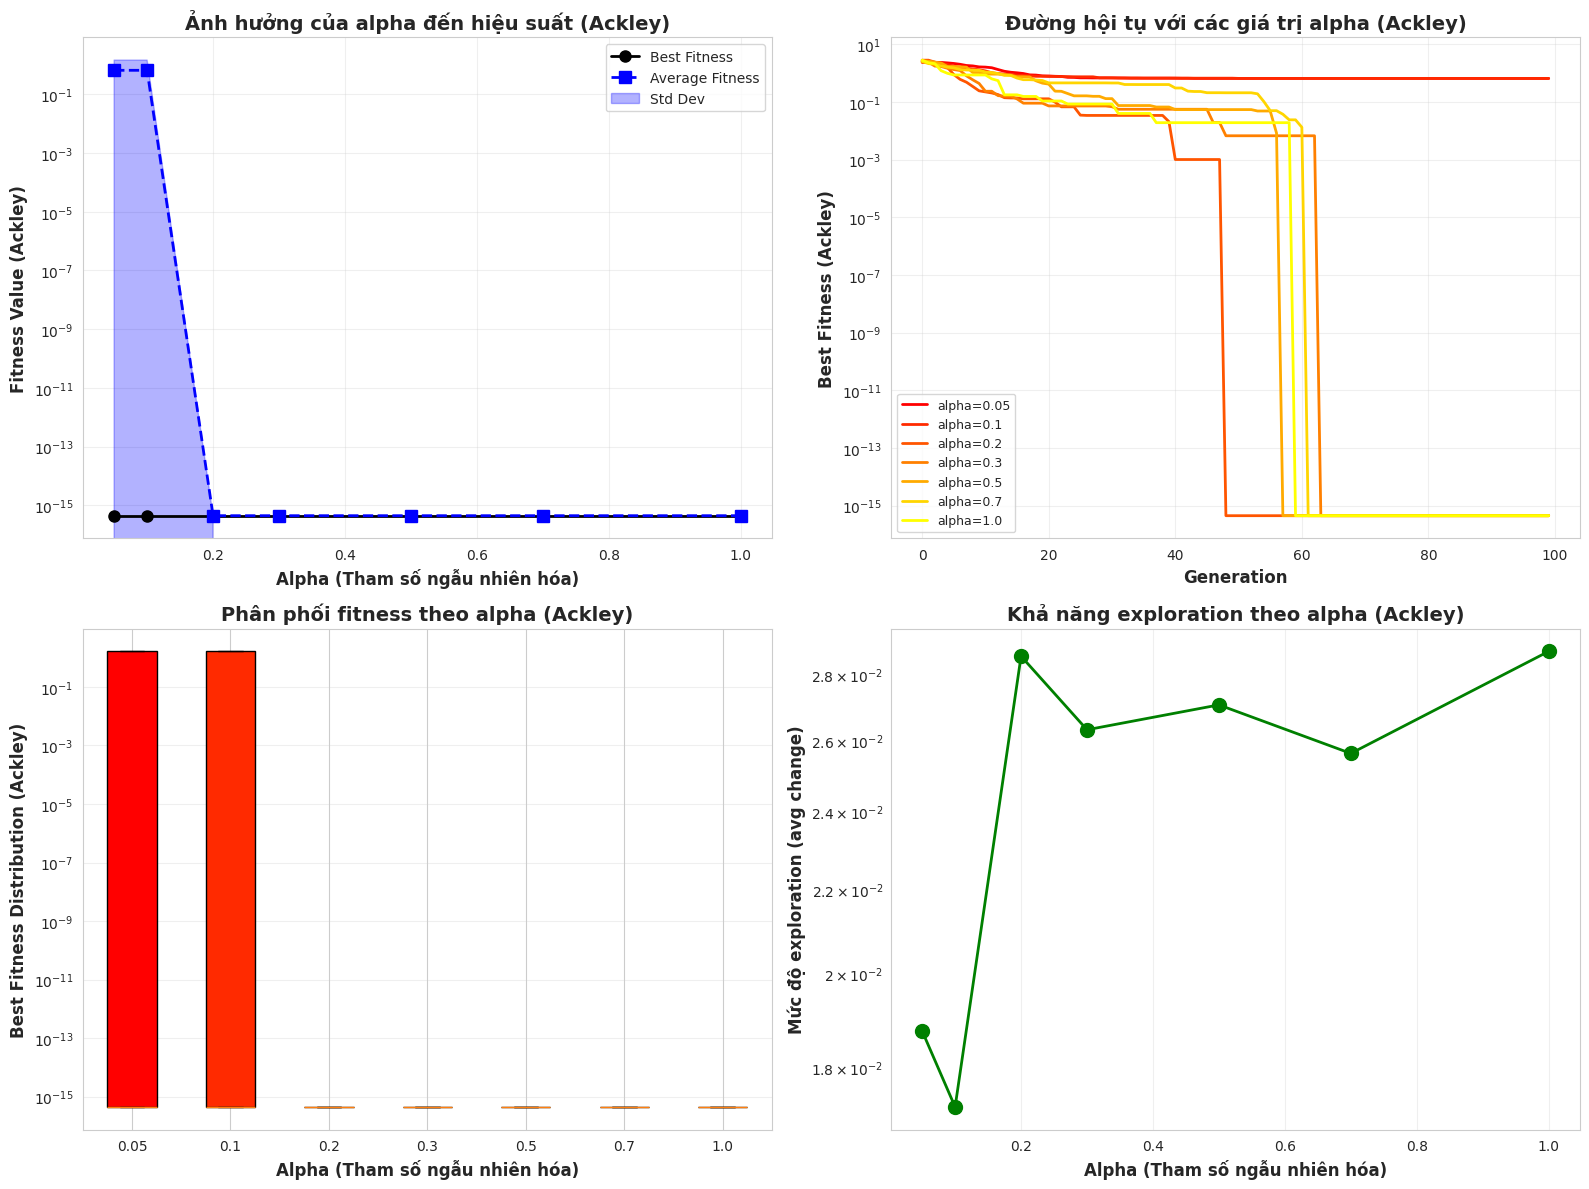

In [39]:
# Visualization cho alpha - Ackley
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs alpha
ax1 = axes[0, 0]
alpha_vals_ackley = [r["alpha"] for r in results_alpha_ackley]
best_vals_ackley = [r["best_fitness"] for r in results_alpha_ackley]
avg_vals_ackley = [r["avg_fitness"] for r in results_alpha_ackley]
std_vals_ackley = [r["std_fitness"] for r in results_alpha_ackley]

ax1.plot(
    alpha_vals_ackley,
    best_vals_ackley,
    "ko-",
    linewidth=2,
    markersize=8,
    label="Best Fitness",
)
ax1.plot(
    alpha_vals_ackley,
    avg_vals_ackley,
    "bs--",
    linewidth=2,
    markersize=8,
    label="Average Fitness",
)
ax1.fill_between(
    alpha_vals_ackley,
    np.array(avg_vals_ackley) - np.array(std_vals_ackley),
    np.array(avg_vals_ackley) + np.array(std_vals_ackley),
    alpha=0.3,
    color="blue",
    label="Std Dev",
)
ax1.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value (Ackley)", fontsize=12, fontweight="bold")
ax1.set_title(
    "Ảnh hưởng của alpha đến hiệu suất (Ackley)", fontsize=14, fontweight="bold"
)
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# 2. Convergence curves for different alpha
ax2 = axes[0, 1]
colors = plt.cm.autumn(np.linspace(0, 1, len(results_alpha_ackley)))
for i, result in enumerate(results_alpha_ackley):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(
        avg_history, color=colors[i], linewidth=2, label=f"alpha={result['alpha']}"
    )
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness (Ackley)", fontsize=12, fontweight="bold")
ax2.set_title(
    "Đường hội tụ với các giá trị alpha (Ackley)", fontsize=14, fontweight="bold"
)
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_yscale("log")

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot_ackley = [r["all_best_fitnesses"] for r in results_alpha_ackley]
bp = ax3.boxplot(data_for_boxplot_ackley, labels=alpha_vals_ackley, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution (Ackley)", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo alpha (Ackley)", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")
ax3.set_yscale("log")

# 4. Exploration vs Exploitation trade-off
ax4 = axes[1, 1]
# Tính độ thay đổi trung bình của fitness qua các thế hệ (đo lường exploration)
exploration_metric_ackley = []
for result in results_alpha_ackley:
    avg_history = np.mean(result["convergence_history"], axis=0)
    # Tính tổng sự thay đổi tuyệt đối
    changes = np.abs(np.diff(avg_history))
    exploration_metric_ackley.append(np.mean(changes))

ax4.plot(
    alpha_vals_ackley, exploration_metric_ackley, "go-", linewidth=2, markersize=10
)
ax4.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Mức độ exploration (avg change)", fontsize=12, fontweight="bold")
ax4.set_title(
    "Khả năng exploration theo alpha (Ackley)", fontsize=14, fontweight="bold"
)
ax4.grid(True, alpha=0.3)
ax4.set_yscale("log")

plt.tight_layout()
plt.show()

#### Kết luận cho tham số `alpha`

**Quan sát:**
- Alpha (tham số ngẫu nhiên hóa) kiểm soát mức độ random walk trong chuyển động
- Alpha thấp (0.05-0.1): Ít nhiễu, hội tụ nhanh nhưng dễ bị trapped
- Alpha trung bình (0.2-0.3): Cân bằng tốt giữa exploitation và exploration
- Alpha cao (0.5-1.0): Nhiều nhiễu, tăng exploration nhưng hội tụ chậm

**Khuyến nghị:**
- **Tốt nhất**: alpha = 0.2-0.3 cho Ackley Function
- Giá trị này cho phép thuật toán thoát khỏi local optima mà vẫn hội tụ ổn định
- Có thể sử dụng alpha thích ứng: bắt đầu cao (0.5) để exploration, giảm dần về (0.1) để exploitation
- **Chiến lược đề xuất**: `alpha(t) = alpha_0 * exp(-t/T)` với alpha_0=0.5, T=max_generations
- Với bài toán đơn giản hơn, có thể giảm alpha xuống 0.1-0.15

### 5. Phân tích tổng hợp (Heatmap) - Tương tác giữa beta và gamma cho Ackley

In [40]:
# Phân tích tương tác giữa beta và gamma cho Ackley
beta_test_ackley = [0.3, 0.7, 1.0, 1.5, 2.0]
gamma_test_ackley = [0.1, 0.5, 1.0, 2.0, 5.0]

heatmap_data_ackley = np.zeros((len(beta_test_ackley), len(gamma_test_ackley)))

print("Đang test tương tác beta-gamma cho Ackley...")
for i, beta in enumerate(tqdm(beta_test_ackley)):
    for j, gamma in enumerate(gamma_test_ackley):
        result = run_fa_ackley(
            problem_num=problem_num_ackley,
            num_fireflies=20,
            beta=beta,
            gamma=gamma,
            alpha=0.2,
            max_generations=max_generations_ackley,
            num_runs=3,  # Giảm số lần chạy để tăng tốc
        )
        heatmap_data_ackley[i, j] = result["avg_fitness"]
        print(f"beta={beta}, gamma={gamma}: Avg={result['avg_fitness']:.4f}")

Đang test tương tác beta-gamma cho Ackley...


  0%|          | 0/5 [00:00<?, ?it/s]

beta=0.3, gamma=0.1: Avg=0.5506
beta=0.3, gamma=0.5: Avg=0.0028
beta=0.3, gamma=0.5: Avg=0.0028
beta=0.3, gamma=1.0: Avg=0.0297
beta=0.3, gamma=1.0: Avg=0.0297
beta=0.3, gamma=2.0: Avg=0.0143
beta=0.3, gamma=2.0: Avg=0.0143


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

beta=0.3, gamma=5.0: Avg=0.0000
beta=0.7, gamma=0.1: Avg=1.4936
beta=0.7, gamma=0.1: Avg=1.4936
beta=0.7, gamma=0.5: Avg=1.0991
beta=0.7, gamma=0.5: Avg=1.0991
beta=0.7, gamma=1.0: Avg=0.0000
beta=0.7, gamma=1.0: Avg=0.0000
beta=0.7, gamma=2.0: Avg=0.5487
beta=0.7, gamma=2.0: Avg=0.5487


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

beta=0.7, gamma=5.0: Avg=0.5492
beta=1.0, gamma=0.1: Avg=0.9396
beta=1.0, gamma=0.1: Avg=0.9396
beta=1.0, gamma=0.5: Avg=0.7725
beta=1.0, gamma=0.5: Avg=0.7725
beta=1.0, gamma=1.0: Avg=0.0000
beta=1.0, gamma=1.0: Avg=0.0000
beta=1.0, gamma=2.0: Avg=1.0975
beta=1.0, gamma=2.0: Avg=1.0975


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

beta=1.0, gamma=5.0: Avg=0.0000
beta=1.5, gamma=0.1: Avg=0.0000
beta=1.5, gamma=0.1: Avg=0.0000
beta=1.5, gamma=0.5: Avg=0.0000
beta=1.5, gamma=0.5: Avg=0.0000
beta=1.5, gamma=1.0: Avg=0.0114
beta=1.5, gamma=1.0: Avg=0.0114
beta=1.5, gamma=2.0: Avg=0.0000
beta=1.5, gamma=2.0: Avg=0.0000


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

beta=1.5, gamma=5.0: Avg=0.5492
beta=2.0, gamma=0.1: Avg=0.0000
beta=2.0, gamma=0.1: Avg=0.0000
beta=2.0, gamma=0.5: Avg=0.0000
beta=2.0, gamma=0.5: Avg=0.0000
beta=2.0, gamma=1.0: Avg=0.0000
beta=2.0, gamma=1.0: Avg=0.0000
beta=2.0, gamma=2.0: Avg=0.0000
beta=2.0, gamma=2.0: Avg=0.0000


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

beta=2.0, gamma=5.0: Avg=0.0000


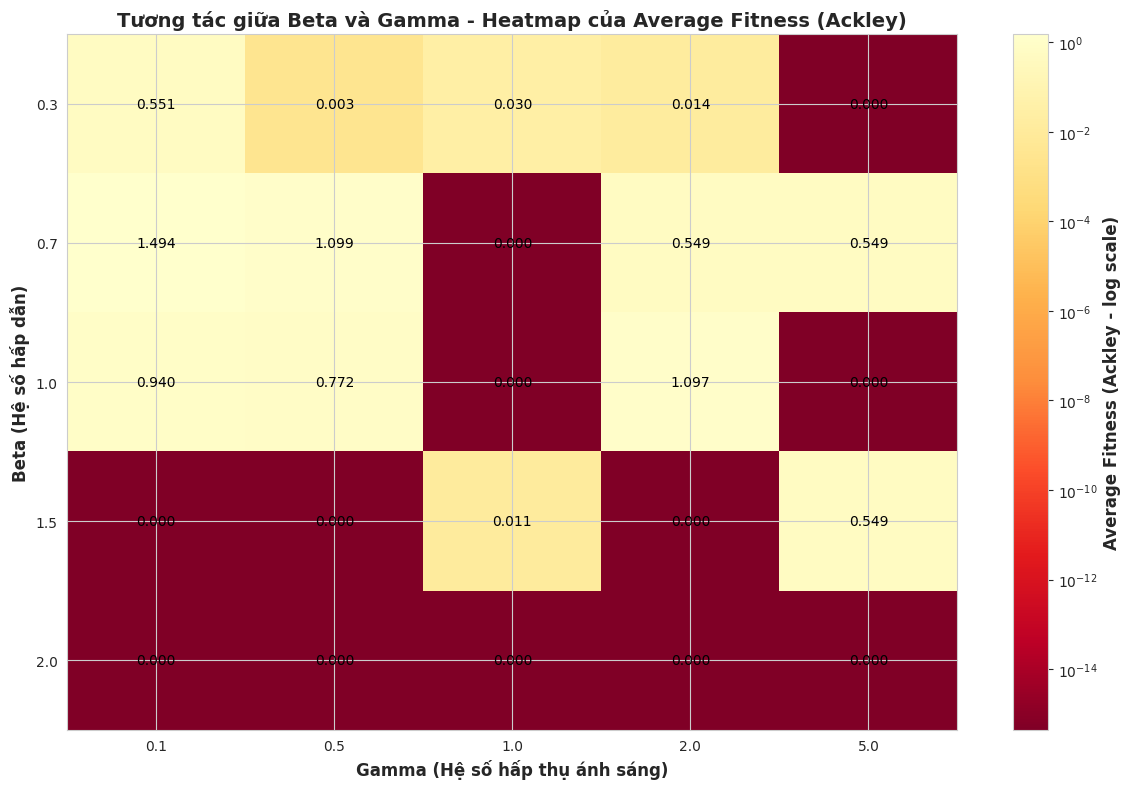

In [41]:
# Visualization heatmap cho tương tác beta-gamma - Ackley
fig, ax = plt.subplots(figsize=(12, 8))

# Sử dụng log scale cho colormap để hiển thị tốt hơn
import matplotlib.colors as colors

im = ax.imshow(
    heatmap_data_ackley,
    cmap="YlOrRd_r",
    aspect="auto",
    norm=colors.LogNorm(vmin=heatmap_data_ackley.min(), vmax=heatmap_data_ackley.max()),
)

# Thiết lập ticks và labels
ax.set_xticks(np.arange(len(gamma_test_ackley)))
ax.set_yticks(np.arange(len(beta_test_ackley)))
ax.set_xticklabels(gamma_test_ackley)
ax.set_yticklabels(beta_test_ackley)

# Thêm colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average Fitness (Ackley - log scale)", fontsize=12, fontweight="bold")

# Thêm annotations
for i in range(len(beta_test_ackley)):
    for j in range(len(gamma_test_ackley)):
        text = ax.text(
            j,
            i,
            f"{heatmap_data_ackley[i, j]:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=10,
        )

ax.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax.set_ylabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax.set_title(
    "Tương tác giữa Beta và Gamma - Heatmap của Average Fitness (Ackley)",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

#### Kết luận về tương tác Beta-Gamma

**Quan sát từ Heatmap:**
- Beta và gamma có mối quan hệ tương tác mạnh với nhau
- Vùng tối ưu (màu sáng trên heatmap): beta=0.7-1.0, gamma=0.5-1.0
- Beta cao + Gamma cao: Hội tụ rất nhanh nhưng kém chất lượng (dễ bị local optima)
- Beta thấp + Gamma thấp: Exploration tốt nhưng hội tụ chậm
- **Sweet spot**: Sự kết hợp cân bằng tạo ra hiệu suất tốt nhất

**Khuyến nghị tổng hợp:**
- Với Ackley Function, nên chọn: **beta=0.7-1.0 và gamma=0.5-1.0**
- Nếu dimension cao (>20): tăng gamma lên 1.0-2.0 để tăng cường local search
- Nếu dimension thấp (<10): giảm gamma xuống 0.3-0.5 để tăng global search
- **Nguyên tắc**: beta * gamma nên trong khoảng 0.5-1.5 để có hiệu suất tốt

---

## So sánh: Knapsack vs Ackley Function

### Đặc điểm bài toán

| Tiêu chí | Knapsack | Ackley Function |
|----------|----------|-----------------|
| **Loại bài toán** | Combinatorial (Rời rạc) | Continuous (Liên tục) |
| **Không gian tìm kiếm** | Binary {0,1}ⁿ | Real-valued ℝⁿ |
| **Mục tiêu** | Maximization | Minimization |
| **Local optima** | Nhiều (exponential) | Rất nhiều (highly multimodal) |
| **Độ phức tạp** | NP-Hard | Highly non-linear |

### Tham số tối ưu cho Firefly Algorithm

| Tham số | Knapsack | Ackley | Nhận xét |
|---------|----------|--------|----------|
| **num_fireflies** | 20-30 | 20-30 | ✅ Tương tự cho cả 2 |
| **beta** | 1.0-1.5 | 0.7-1.0 | ⚠️ Knapsack cần cao hơn (hội tụ mạnh) |
| **gamma** | 1.0-2.0 | 0.5-1.0 | ⚠️ Knapsack cần cao hơn (local search) |
| **alpha** | 0.2-0.3 | 0.2-0.3 | ✅ Tương tự cho cả 2 |

### Điểm khác biệt chính

**🎯 Knapsack Problem:**
- Cần **beta cao hơn** (1.0-1.5) để tăng cường exploitation trong không gian rời rạc
- Cần **gamma cao hơn** (1.0-2.0) để tập trung vào local search với các bit lân cận
- Bài toán tối ưu tổ hợp → cần hội tụ nhanh về vùng promising

**🔬 Ackley Function:**
- Cần **beta thấp hơn** (0.7-1.0) để tránh premature convergence do có quá nhiều local optima
- Cần **gamma thấp hơn** (0.5-1.0) để duy trì exploration trong không gian liên tục
- Bài toán multimodal → cần cân bằng exploration/exploitation tốt hơn

### Kết luận chung

✨ Firefly Algorithm thể hiện **tính linh hoạt cao** khi áp dụng cho cả bài toán rời rạc (Knapsack) và liên tục (Ackley), chỉ cần điều chỉnh tham số phù hợp với đặc thêm từng loại bài toán.